# Housing Price Prediction in London:
## A predictive analysis based on property advertisement texts


***
<em> <div style="font-size: 20px"> About this document </div> 
This is the code implementation for MSc dissertation     
Centre for Advanced Spatial Analysis, Bartlett Faculty of the Build Environment, UCL    
22 August 2022 


***

In [1]:
# Load libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
import re
import pysal
import random
import json
import glob
import urllib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import sklearn
import plotly.express as px

from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn import model_selection

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load libraries 
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations

import spacy  # For preprocessing
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))


from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()


import contractions
from contractions import contractions_dict # from contractions.py
import string

import ast

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Load data and study area

### 1.1 Zoopla Property Data

In [2]:
data=pd.read_csv('london_zoopla/combined_csv.csv')
data.shape

(424231, 50)

In [3]:
data.columns

Index(['listing_id', 'property_type', 'start_date', 'end_date', 'price_first',
       'price_last', 'price_min', 'price_max', 'price_unique', 'price_flag',
       'num_bed_first', 'num_bed_last', 'num_bed_min', 'num_bed_max',
       'bed_flag', 'num_floors_min', 'num_floors_max', 'num_bath_min',
       'num_bath_max', 'num_reception_min', 'num_reception_max', 'pcu', 'lon',
       'lat', 'address', 'street_name', 'property_num', 'post_town', 'country',
       'county', 'listing_status', 'epc_list', 'details_url',
       'short_description', 'category', 'description', 'zdocument',
       'branch_id', 'image_url', 'agent_logo', 'agent_name', 'agent_phone',
       'agent_address', 'agent_postcode', 'image_caption', 'thumbnail_url',
       'floor_plan', 'original_image', 'bullet', 'lad20nm'],
      dtype='object')

In [4]:
# drop duplicated columns 
data=data.drop_duplicates(subset=['listing_id'], keep='last')
print(data.shape)

(146579, 50)


In [5]:
data.to_csv('london_data_remove_dup.csv',index=False, encoding='utf-8-sig')

In [6]:
# select possible used columns 
df=data[['listing_id',
       'price_last','property_type', 
       'num_bed_last','num_floors_max','num_bath_max','num_reception_max',
       'bullet','lad20nm']]
df.head(3)

listing_id  price_last property_type  num_bed_last  num_floors_max  \
8     47727957      900000          Flat             1               0   
17    58128970      700000          Flat             2               0   
27    56201687     1200000          Flat             4               0   

    num_bath_max  num_reception_max  \
8              1                  1   
17             2                  1   
27             2                  1   

                                               bullet         lad20nm  
8   ["511 sqft", "1st floor", "999 year lease", "E...  City of London  
17       ["Balcony", "Central heating", "Waterfront"]  City of London  
27  ["Four bedrooms", "Two bathrooms", "Second flo...  City of London

In [7]:
# drop null value
df=df.dropna()
df.shape

(138645, 9)

In [8]:
df.to_csv('london_data.csv',index=False, encoding='utf-8-sig')

In [9]:
#start from here
df=pd.read_csv('london_data.csv')

In [10]:
#create sub-regions
#the boroughs in sub regions 
#reference: https://www.wikiwand.com/en/List_of_sub-regions_used_in_the_London_Plan
sub_regions= {'central': ['Camden', 'City of London', 'Kensington and Chelsea', 'Islington', 'Lambeth', 'Southwark', 'Westminster'],
             'east':['Barking and Dagenham', 'Bexley', 'Greenwich', 'Hackney', 'Havering', 'Lewisham', 'Newham', 'Redbridge', 'Tower Hamlets', 'Waltham Forest'],
             'north': ['Barnet', 'Enfield', 'Haringey'],
             'south': ['Bromley', 'Croydon', 'Kingston upon Thames', 'Merton', 'Sutton', 'Wandsworth'],
             'west': ['Brent', 'Ealing', 'Hammersmith and Fulham', 'Harrow', 'Hillingdon', 'Hounslow','Richmond upon Thames']}

#reverse the dict
res={value: key for key, values in sub_regions.items() for value in values}
print(len(res))

#mapping the boroughs to sub regions
df['sub_regions']=df['lad20nm'].map(res)
df['sub_regions'].value_counts()

33


central    44201
east       37456
west       19925
south      19370
north      17635
Name: sub_regions, dtype: int64

In [11]:
df['sub_regions']=df['lad20nm'].map(res)

In [12]:
#check the mismatched properties 
print(df[df['sub_regions'].isnull()].lad20nm.unique(),'is not matched to the London sub-regions,thus,',df['sub_regions'].isnull().sum(),'mismatched properties thus will be removed from our analysis.')
#drop these values
df=df.dropna()

print('now,', len(df), 'records remain.')

['Epping Forest'] is not matched to the London sub-regions,thus, 58 mismatched properties thus will be removed from our analysis.
now, 138587 records remain.


In [13]:
#drop lad20nm column
df.drop('lad20nm', axis=1, inplace=True)

### 1.2 Study area 

In [14]:
import geopandas as gpd
import requests
import zipfile
import io
import matplotlib.pyplot as plt

#a function used to download zipped geographic boundary data and save it locally 

def ds_shp(url, foldername):
    """downloading zipped shapefiles and save them locally.
    
    The function downloads remote zipped shapefiles,
    unzips files and saves them locally. If the destination
    folder has not been created, the function will
    automatelly create a folder to save the files.
    
    Parameters
    ----------
    url : str
        The url link of the zipped shapfiles.
    foldername : str
        The *destination* location to save the file.
        
    Returns
    -------
    filenames : printing a list of saved filenames.
    
    """
    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    path = os.path.join('dataset',foldername)
    if not os.path.exists(path):
        print(f"Creating {path} under {os.getcwd()}")
        os.makedirs(path)
    z.extractall(path=path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    
#downloading shpfiles
ds_shp('https://data.london.gov.uk/download/sub-regions-london-plan-consultation-2009/ab02f0a3-ba7b-4384-b850-bddc28af29a9/lp-consultation-oct-2009-subregions-shp.zip'
,'raw')  
    

Done


In [15]:
# reading the london sub_regions 
london_sub_regions=gpd.read_file('dataset/raw/lp-consultation-oct-2009-subregions.shp')

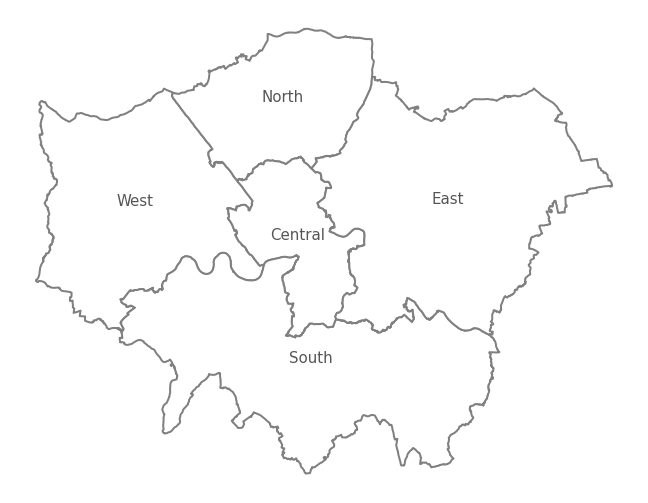

In [16]:
f,ax = plt.subplots(figsize=(15,9))
london_sub_regions.plot(edgecolor='gray', facecolor='white', linewidth=2,ax=ax)
london_sub_regions.apply(lambda x: ax.annotate(text=x['Name'], xy=x.geometry.centroid.coords[0], ha='center',fontsize=15, fontweight=4, color='#555555'), axis=1);
ax.axis('off') #don't plot the axes (bounding box)
# ax.set_title('London Sub Regions', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
f.savefig('study_area.png', dpi=150)

## 2. Exploratory Data Analysis

In [17]:
df.columns

Index(['listing_id', 'price_last', 'property_type', 'num_bed_last',
       'num_floors_max', 'num_bath_max', 'num_reception_max', 'bullet',
       'sub_regions'],
      dtype='object')

In [18]:
#check the columns and the data type of each column 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138587 entries, 0 to 138644
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   listing_id         138587 non-null  int64 
 1   price_last         138587 non-null  int64 
 2   property_type      138587 non-null  object
 3   num_bed_last       138587 non-null  int64 
 4   num_floors_max     138587 non-null  int64 
 5   num_bath_max       138587 non-null  int64 
 6   num_reception_max  138587 non-null  int64 
 7   bullet             138587 non-null  object
 8   sub_regions        138587 non-null  object
dtypes: int64(6), object(3)
memory usage: 10.6+ MB


### price_last

skew:  17.049495672821752


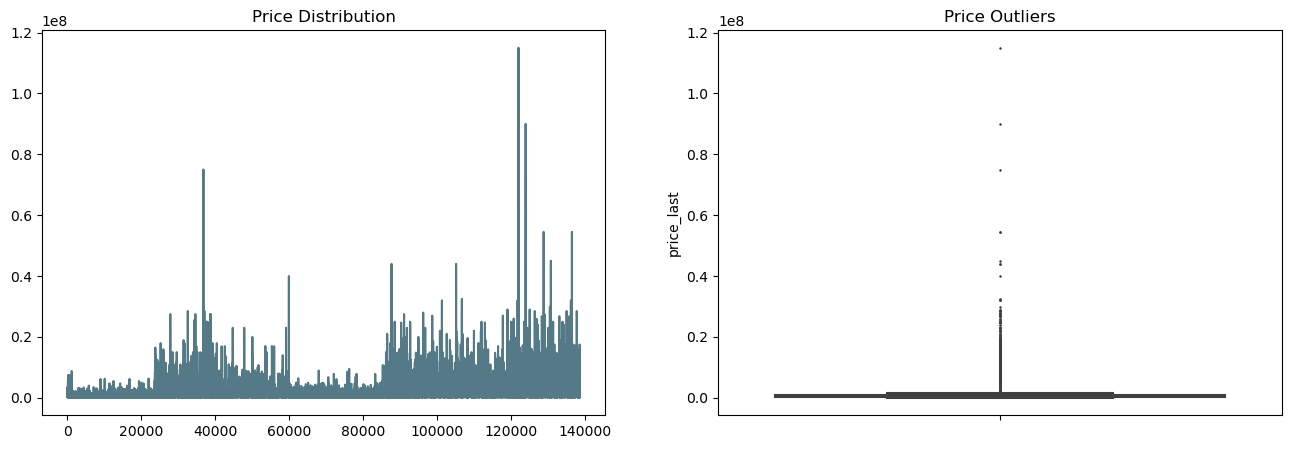

In [19]:
# distribution and outliers of price values 
import scipy.stats as stats
plt.style.use('default')
plt.figure(figsize=(16,5))

# check the distribution of y variable - price per square meter 
plt.subplot(1, 2, 1)
plt.title("Price Distribution")
plt.plot(df.price_last,'#547987')

# ax = df.price_last.plot.kde()
# plt.hist(df.price_last,color='#547987')
# ax= sns.displot(df, x="price_last", kind="kde")
# check price per square outliers
plt.subplot(1, 2, 2)

plt.title("Price Outliers")
ax=sns.boxplot(y=df['price_last'],
                   palette=sns.diverging_palette(220, 20),
                  fliersize=0.9)


    
#check the skew
print('skew: ',df.price_last.skew())



skew:  0.9278487996340906


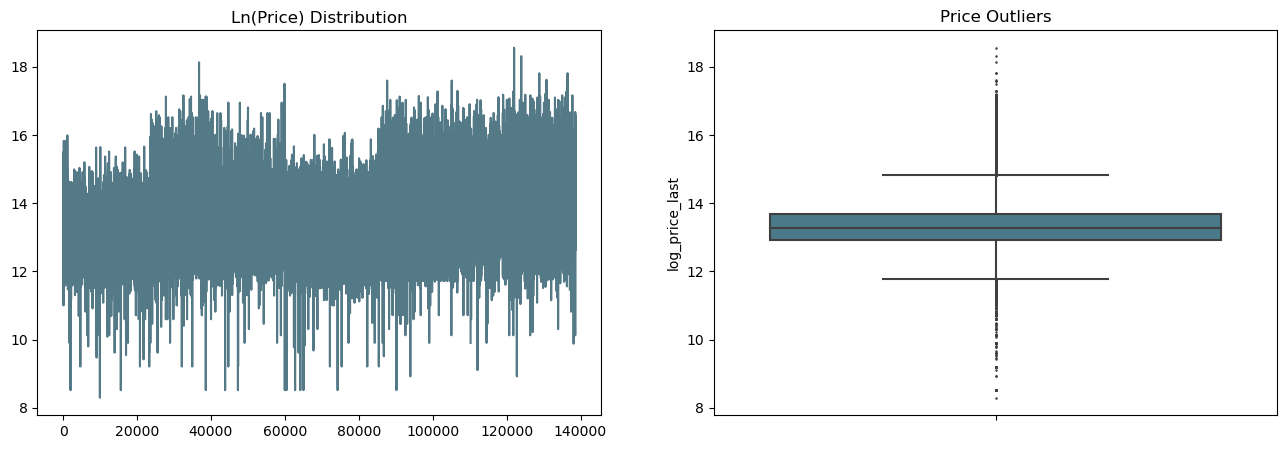

In [20]:
# distribution and outliers of *log* price values 

df['log_price_last'] = np.log(df[df.price_last>0].price_last)

plt.figure(figsize=(16,5))

# check the distribution of y variable - price per square meter 
plt.subplot(1, 2, 1)
plt.title("Ln(Price) Distribution")
plt.plot(df.log_price_last,'#547987')

# check price per square outliers
plt.subplot(1, 2, 2)

plt.title("Price Outliers")
sns.boxplot(y=df.log_price_last,
                   palette=sns.diverging_palette(220, 20),
                  fliersize=0.9)


    
#check the skew
print('skew: ',df.log_price_last.skew())



price skew:  17.049495672821752
logged price skew:  0.9278487996340906


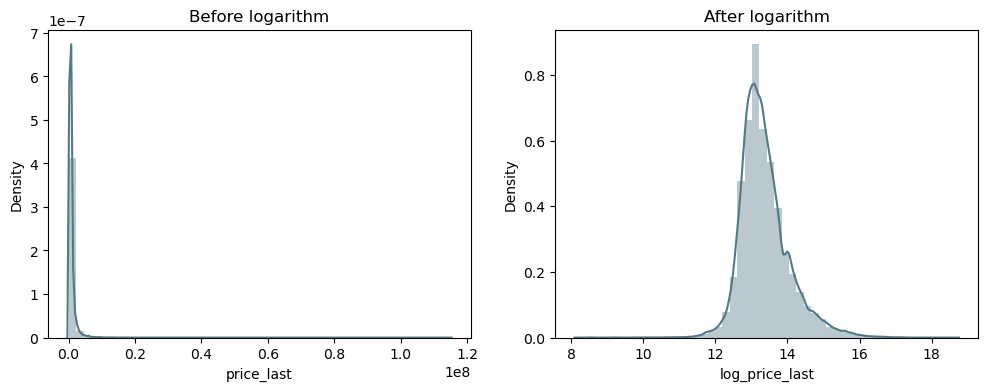

In [21]:
# check the distribution of y variable - price_last vs lo_price_last
fig,axes=plt.subplots(1,2,figsize=(12,4))

a1=df.price_last
sns.distplot(a1,color="#547987",ax=axes[0]).set_title("Before logarithm")
#check the skew
print('price skew: ',df.price_last.skew())

a2=df.log_price_last
sns.distplot(a2,color="#547987",ax=axes[1]).set_title("After logarithm")
#check the skew
print('logged price skew: ',df.log_price_last.skew())


In [22]:
#dealling with outliers 
def detect_outliers(sr):
    q1 = sr.quantile(0.25)
    q3 = sr.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers = sr.loc[(sr < fence_low) | (sr > fence_high)]
    print(f'Low: {fence_low:.4f}, High: {fence_high:.4f}')
    return outliers

# check the outliers 
outliers=df.loc[detect_outliers(df.log_price_last).index].sort_values(by=['log_price_last'])
print('Number of outliers:',outliers.value_counts().sum())
print(f'  Lower fence is at {outliers[outliers.price_last < 250000].price_last.max():,}')
print(f'  Upper fence is at {outliers[outliers.price_last > 250000].price_last.min():,}')
print('The 5 largest price_last: ',df.nlargest(5,'price_last').price_last.tolist())
print('The 5 smallest price_last: ',df.nsmallest(5,'price_last').price_last.tolist())


Low: 11.7868, High: 14.8191
Number of outliers: 6155
  Lower fence is at 131,250
  Upper fence is at 2,735,000
The 5 largest price_last:  [115000000, 90000000, 75000000, 54500000, 54500000]
The 5 smallest price_last:  [0, 0, 0, 0, 0]


In [23]:
pd.set_option('display.float_format', lambda x: f'{x:,}')

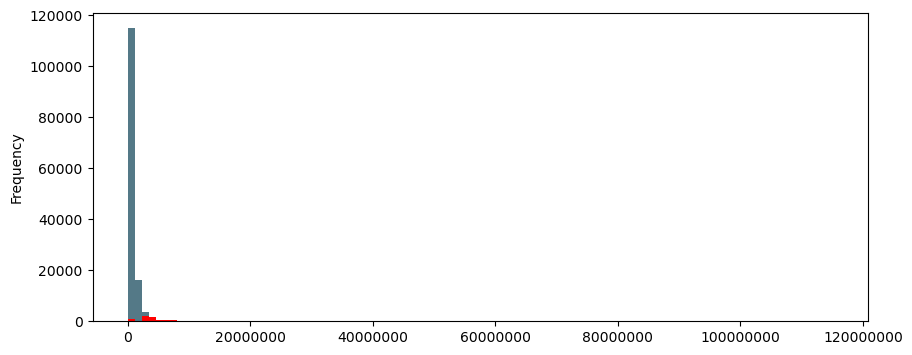

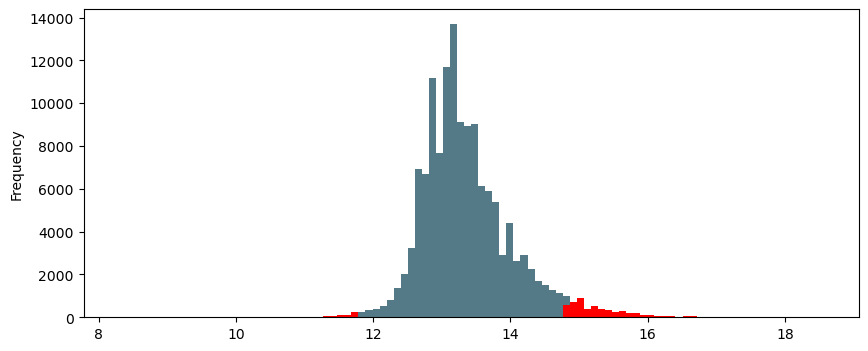

In [24]:
#plot price visualization before and after log 
f,ax = plt.subplots(1,1,figsize=(10,4))
df.price_last.plot.hist(bins=100, ax=ax,color='#547987')
outliers.price_last.plot.hist(bins=100, ax=ax, color='red')
ax.ticklabel_format(useOffset=False, style='plain')

f,ax = plt.subplots(1,1,figsize=(10,4))
df.log_price_last.plot.hist(bins=100, ax=ax,color='#547987')
outliers.log_price_last.plot.hist(bins=100, ax=ax, color='red')
ax.ticklabel_format(useOffset=False, style='plain')

Though there are 674 outliers (257 if you use the log price), considering the distribution could be a possible feature of housing price, we will not drop all outliers. Checking the five largest and smallest price_last values, 0 value are considered unreasonable. So 0 is kicked out.


In [25]:
#dropping abnormal values 0 
df=df.drop(df[(df['price_last']==0)].index)
df.shape

(138471, 10)

### Property_type

In [26]:
len(df['property_type'].unique())

33

In [27]:
df['property_type'].value_counts()

Flat                      84822
Terraced house            24452
Semi-detached house        9033
Maisonette                 6356
End terrace house          4878
Detached house             3877
Studio                     2610
Town house                  745
Mews house                  625
Bungalow                    176
Land                        166
Cottage                     131
Link-detached house         105
Block of flats               95
Semi-detached bungalow       94
Parking/garage               86
Houseboat                    83
Detached bungalow            67
Retail premises              26
Barn conversion               8
Terraced bungalow             8
Chalet                        5
Restaurant/cafe               4
Villa                         4
Lodge                         3
Office                        3
Hotel/guest house             2
Mobile/park home              2
Country house                 1
Business park                 1
Industrial                    1
Leisure/

[Text(0.5, 1.0, 'Distribution of Property Type')]

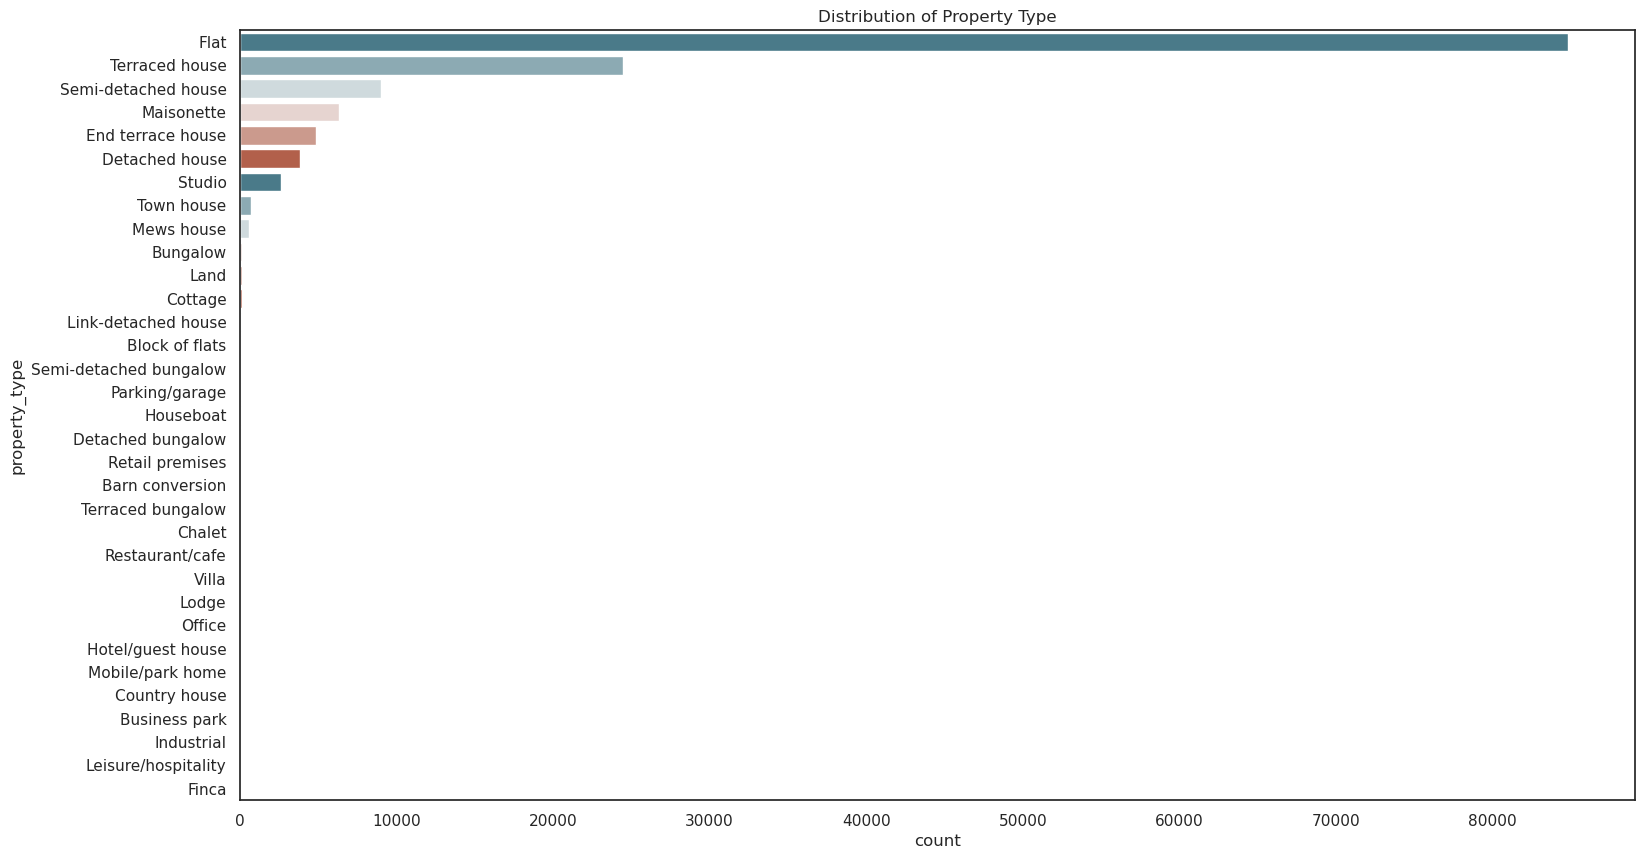

In [28]:
# plotting age band distribution 
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style('white')
ax=sns.countplot(y="property_type",palette=sns.diverging_palette(220, 20), data=df,order = df['property_type'].value_counts().index)
ax.set(title='Distribution of Property Type')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha="right")

#select major types of distribution of property type for dummy variables 
# 'End terrace house', 'Flat', 'Studio', 'Maisonette','Semi-detached house', 'Detached house','Terraced house'

### Numerical columns: bed, bathroom, reception, floor

Text(0.5, 0.98, 'Distribution of logged price in numerical variables')

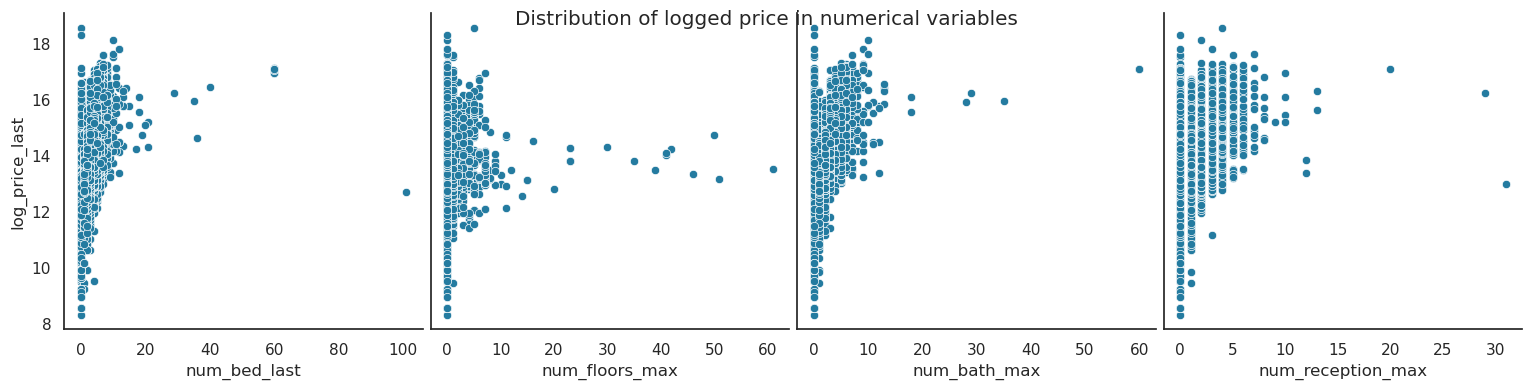

In [29]:
#plotting the relation between priceper and numerical variables 

g=sns.pairplot(
    df,
    x_vars=['num_bed_last','num_floors_max','num_bath_max','num_reception_max'],
    y_vars=['log_price_last'],    
    height=3.9,
    plot_kws={'color': '#247ba0' },
)

g.fig.suptitle("Distribution of logged price in numerical variables")



In [30]:
#check the bathrooms
# df[(df['num_bath_max']==0) & (df['num_bed_last']==2)]

In [31]:
#check the bathrooms == 0 
len(df[(df['num_bath_max']==0)])

14001

In [32]:
#dropping abnormal values 0 
df=df.drop(df[(df['num_bath_max']==0)].index)
df.shape

(124470, 10)

###  preprocessing before regression, get dummy variables

In [33]:
#drop bullet column
# df_temp=df.drop('bullet', axis=1).set_index('listing_id')
df_temp=df.drop(['bullet','listing_id'], axis=1) # drop or remian the listing-id
# get dummy variables 
df_dummy=pd.get_dummies(df_temp)
df_dummy.columns


Index(['price_last', 'num_bed_last', 'num_floors_max', 'num_bath_max',
       'num_reception_max', 'log_price_last', 'property_type_Barn conversion',
       'property_type_Block of flats', 'property_type_Bungalow',
       'property_type_Business park', 'property_type_Chalet',
       'property_type_Cottage', 'property_type_Detached bungalow',
       'property_type_Detached house', 'property_type_End terrace house',
       'property_type_Finca', 'property_type_Flat',
       'property_type_Hotel/guest house', 'property_type_Houseboat',
       'property_type_Industrial', 'property_type_Land',
       'property_type_Link-detached house', 'property_type_Lodge',
       'property_type_Maisonette', 'property_type_Mews house',
       'property_type_Mobile/park home', 'property_type_Office',
       'property_type_Parking/garage', 'property_type_Restaurant/cafe',
       'property_type_Retail premises', 'property_type_Semi-detached bungalow',
       'property_type_Semi-detached house', 'property_typ

In [34]:
#drop useless dummies, only remain the property_type with a great amount of numbers 
df_dummy=df_dummy[['log_price_last','num_bed_last', 'num_floors_max', 'num_bath_max','num_reception_max',
                   'property_type_End terrace house', 'property_type_Flat', 'property_type_Studio', 'property_type_Maisonette','property_type_Semi-detached house', 'property_type_Detached house','property_type_Terraced house',
                  'sub_regions_central', 'sub_regions_east', 'sub_regions_north','sub_regions_south', 'sub_regions_west']]
#let's check the number of columns and rows
df_dummy.shape

(124470, 17)

## 3. NLP analysis: dealing with bullet

### 3.1 Text Cleaning

In [35]:
# the text preprocessing procedures 

# Reference: https://www.kaggle.com/code/vukglisovic/classification-combining-lda-and-word2vec
# Reference: https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0
# Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/



# function to remove html
def removing_html(text):
    from bs4 import BeautifulSoup
    removing_html_text = []
    for l in text:
    # What is this regex doing? Maybe 'view source' the URL?
        tmp = re.sub(r'(\/[A-Za-z]+\d?|[A-Za-z]+ \/)>','\\1> ', l)
        soup = BeautifulSoup(tmp, "html.parser")
        # What is going on here?
        if not re.match(r'^\s*$',soup.get_text()):
            removing_html_text.append(soup.get_text())
    return removing_html_text


# function to remove accented characters
def removing_accented_chars(text):
    import unicodedata
    removing_accented_text = []
    for l in text:
        new_text = unicodedata.normalize('NFKD', l).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        removing_accented_text.append(new_text)
    return removing_accented_text            


# function to expand contractions
def expand_contractions(text):
    expand_contractions_text = []
    for l in text:
        expanded_words = []
        for word in l.split():
        # using contractions.fix to expand the shortened words
            expanded_words.append(contractions.fix(word))  
        expanded_sentence= ' '.join(expanded_words)
        expand_contractions_text.append(expanded_sentence)
    return expand_contractions_text


# function to remove special characters
def removing_special_characters(text):
    removing_special_characters =[]
    # define the pattern to keep
    pat = r'[^a-zA-z0-9,]' 
    for l in text:
#         new_text=text.replace("[]", " ")  
#         new_text=new_text.replace("/", " ") 
        new_text=re.sub(pat, ' ', l)
        removing_special_characters.append(new_text)
    return removing_special_characters



# function to remove numbers
def removing_numbers(text):
    removing_numbers =[]
    # define the pattern to keep
    pat = r'[^a-zA-z.,!?/:;\"\'\s]' 
    for l in text:
        new_text=re.sub(pat, ' ', l)
        removing_numbers.append(new_text)
    return removing_numbers

# reference: https://likegeeks.com/python-remove-punctuation/#Remove_all_punctuation_except_apostrophe
# function to remove punctuation
def removing_punctuation(text):
    removing_punctuation =[]
    for l in text:
        tr_table = str.maketrans("","", string.punctuation)
        del tr_table[ord(",")] #deleting ' from translation table
        new_text = ''.join(l.translate(tr_table))
        new_text= new_text.replace(',,',',')
        new_text= new_text.replace(', ,',',')
        removing_punctuation.append(new_text)
    return removing_punctuation




# function to remove extra whitespace tabs
def removing_extra_whitespace_tabs(text):
    removing_extra_whitespace_tabs =[]
    pattern = r'^\s*|\s\s*'
    for l in text:
        new_text= re.sub(pattern, ' ', l).strip()
        removing_extra_whitespace_tabs.append(new_text)
    return removing_extra_whitespace_tabs    
    

# function to Lemmatization 
def get_lem(text):
    # Lemmatize with POS Tag
    def get_wordnet_pos(word):
        from nltk.corpus import wordnet
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)  
    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    lem=[] #blank list
    for l in text:
        t=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(l)] #tokenize sentences into words
        new_text = ' '.join(t)  #put lemmatized word back to sentence 
        lem.append(new_text) # put the sentences back to the description, every property has one paragraph 
    return lem

# function to remove stopwords
def remove_stopwords(text):
    # imports
#     import nltk
#     from nltk.tokenize import ToktokTokenizer
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    tokenizer = ToktokTokenizer()
    stopword_list = nltk.corpus.stopwords.words('english')
       # custom: removing and add words from list
    new_stop_list = ['ft','x','sq','nd','st','sqft','area','square','one','two','three','four','five','six','seven','eight','nine','ftt','th','approx','pcm']
    stopword_list.extend(new_stop_list)
    stopword_list.remove('no')
    stopword_list.remove('off')
    # convert sentence into token of words
    removing_stopwords =[]
    for l in text:
        tokens = tokenizer.tokenize(l)
        tokens = [token.strip() for token in tokens]
        # check in lowercase 
        t = [token for token in tokens if token not in stopword_list]
        new_text = ' '.join(t)  
        removing_stopwords.append(new_text)
    return removing_stopwords


# tokenize the word in each bullet point,   
# reconglise pos tags in the bullet point,    
# if the bullet point only contains CD+NN/NNP, then remove the bullet
#function to identify pos tags 
def pos_tags (text):
    all_tags =[] #contain all the tag results
#how to read word in each sentence
    for bullets in text: 
        print(bullets)
        bullets = list(bullets.split(","))
#         print(bullets) #each rows        
        res = list(map(str.split, bullets))
        property_tags =[] #contain all the property result
#         print(res) #property bullet points
        for i in res:
#             print (i)        
            a=nltk.pos_tag(i)  
            tags =[]
            for l in a:
                tags.append(l[1]) #get tags for each bullet point
#             print(tags)
            property_tags.append(tags) #get all tags for one property
#         print(property_tags) #correspond to res 
        
        all_tags.append(property_tags)
    return all_tags
#     print(all_tags)



#functions to identify pos tags and remove the CD NNS/NN combinations
def removing_tagged_pos (text):
#     all_tags =[] #contain all the tag results
    all_new_bullet =[]
#how to read word in each sentence
    for bullets in text: 
#         print(bullets)
        bullets = list(bullets.split(","))
#         print(bullets) #each rows        
        res = list(map(str.split, bullets))
        property_tags =[] #contain all the property result
#         print(res) #property bullet points
        new_property_bullet = []
        for i in res:
#             print (i)        
            a=nltk.pos_tag(i)  
            tags =[]
            new_bullet =[]
            for l in a:
                tags.append(l[1]) #get tags for each bullet point
#             print(tags)
            if 'JJ' in tags or 'RB' in tags or 'VBG' in tags or 'NN' in tags and tags !=['CD'] and tags !=['NN'] and tags !=['NNS']:
#             if 'JJ' in tags or 'RB' in tags or 'VBG' in tags or 'NN' in tags and tags !=['CD', 'NNS'] and tags !=['CD', 'NN'] and tags !=['CD'] and tags !=['NN'] and tags !=['NNS']: #only select meaningful tags 
#             if tags !=['CD', 'NNS'] and tags !=['CD', 'NN']  and tags !=['CD']: # remove words such as '3 bedrooms', 'one bedroom'
                new_bullet=' '.join(i)
            
            
#             print(new_bullet,'...........end')
#             new_property_bullet=''.join(new_bullet) #add as string 
            new_property_bullet.append(new_bullet) #get new bullets for each property   
#             print('.............',new_property_bullet,'...........end')
        all_new_bullet.append(new_property_bullet) #for all properties 
#         print('here are the new_bullets: ',all_new_bullet)
    return all_new_bullet

In [36]:
# the final text preprocessing function that combines all procedures 
def text_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    """
    df['lower'] = df['bullet'].str.lower() # lower case 
    df['removing_html']=removing_html(df['lower']) #removing html
    df['removing_accented'] = removing_accented_chars(df['removing_html']) # removing_accented
    df['expand_contractions']= expand_contractions(df['removing_accented']) #expand contractions
    df['removing_numbers']= removing_numbers(df['expand_contractions']) #removing numbers 
    df['removing_stopwords'] = remove_stopwords(df['removing_numbers'] ) #remove_stopwords
    df['removing_punctuation'] = removing_punctuation(df['removing_stopwords'])  # removing punctuation but keep ','
    df['removing_tagged_pos'] =removing_tagged_pos(df['removing_punctuation']) #removing bullet such as 3 bedrooms, one bedroom, etc
    df['removing_tagged_pos_str']=df['removing_tagged_pos'].apply(lambda x: ','.join(map(str, x))) #change to string type column
    df['removing_punctuation_1'] = removing_punctuation(df['removing_tagged_pos_str']) #'removing punctuation again 
    df['removing_punctuation_1'] = removing_punctuation(df['removing_punctuation_1']) #'removing punctuation again 
    df['cleaned']=removing_extra_whitespace_tabs(df['removing_punctuation_1']) # removing_extra_whitespace_tabs for the cleaned text
    df['tokens'] = df.apply(lambda row: nltk.sent_tokenize(row['cleaned']), axis=1) #tokenize 



In [37]:
text_preprocessing(df)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# df[['bullet','cleaned','tokens']].tail(50)

In [39]:
#check the preprocessing results
pd.set_option("display.max_colwidth", -1) #get the complete sentences,  
df[['bullet','cleaned','tokens']].sample(n=3,random_state=None)

bullet  \
49615  ["Three Bedroom House", "Semi-detached", "Shared driveway to Side Garage", "Two Reception Room", "Long over 100ft Rear Garden", "Offered Chain Free"]   
12585  []                                                                                                                                                      
24326  []                                                                                                                                                      

                                                                                                          cleaned  \
49615  bedroom house,semi detached,shared driveway side garage,reception room,long rear garden,offered chain free   
12585                                                                                                               
24326                                                                                                               

                                                                                                             tokens  
49615  [bedroom house,semi detached,shared driveway side garage,reception room,long rear garden,offered chain free]  
12585  []                                                                                                            
24326  []

In [40]:
#check the preprocessing results 
#20230
df.loc[20230]


listing_id                 52916302                                                                                                                                                                                                          
price_last                 650000                                                                                                                                                                                                            
property_type              Semi-detached house                                                                                                                                                                                               
num_bed_last               4                                                                                                                                                                                                                 
num_floors_max             0                    

In [41]:
#remove empty bullets properties 

#check empty rows
import numpy as np
df.replace(to_replace=r'^\s*$', value=np.nan, regex=True, inplace=True)
df.cleaned.isnull().sum()

15389

In [42]:
df.dropna( inplace=True)
df.shape

(109081, 22)

In [43]:
df_cleaned=df[['listing_id','cleaned']]
df_cleaned.to_csv('cleaned_bullet.csv')

### 3.2 Overall Frequency

The overall frequency - can help to select which word and related description to analysis 

In [44]:
#get the corpus
corpus=df_cleaned.cleaned.values

#clean the description, remove all commas
a=corpus.tolist()
a=' '.join(str(e) for e in a)
a=a.replace(',',' ')
a=a.replace('  ',' ')

print('number of properties: ', len(corpus))
print('number of words: ', len(a))


number of properties:  109081
number of words:  14016571


In [45]:
#get all unique words 
unique_list_all = []
for i in a.split():
    if i not in unique_list_all:
        unique_list_all.append(i)

len(unique_list_all)

13588

In [46]:
#find out the most frequent words ()
words: list[str] = nltk.word_tokenize(a)
text = nltk.Text(words)
fd = text.vocab()
fd.tabulate(15)

   double      room    garden   kitchen     close     floor reception   bedroom   private   parking  bedrooms     chain  bathroom  location   station 
    43488     41825     40072     30877     29863     29592     27953     27833     27743     26901     23674     21902     18357     18295     17670 


In [47]:
#find out the most frequent QuadgramCollocation
# TrigramCollocationFinder, BigramCollocationFinder, QuadgramCollocationFinder
finder = nltk.collocations.BigramCollocationFinder.from_words(words)
print(finder.ngram_fd.tabulate(15))

('double', 'bedrooms')  ('reception', 'room')      ('chain', 'free')       ('open', 'plan') ('transport', 'links')  ('street', 'parking')      ('off', 'street')     ('rear', 'garden')  ('share', 'freehold') ('central', 'heating')    ('ground', 'floor')  ('private', 'garden')  ('fitted', 'kitchen')     ('first', 'floor')        ('en', 'suite') 
                 20004                  16564                  13351                  12032                  11023                  10493                  10382                   9295                   9247                   9158                   8815                   8338                   7944                   7795                   7717 
None


In [48]:
finder = nltk.collocations.TrigramCollocationFinder.from_words(words)
print(finder.ngram_fd.tabulate(15))

       ('off', 'street', 'parking')           ('no', 'onward', 'chain')       ('gas', 'central', 'heating') ('excellent', 'transport', 'links')         ('open', 'plan', 'kitchen')    ('central', 'heating', 'double')          ('open', 'plan', 'living')       ('south', 'facing', 'garden')    ('heating', 'double', 'glazing')       ('private', 'rear', 'garden')         ('garden', 'off', 'street')     ('close', 'transport', 'links')     ('close', 'local', 'amenities')        ('west', 'facing', 'garden')     ('double', 'reception', 'room') 
                              10180                                5476                                4126                                3712                                3161                                2853                                2548                                2503                                2321                                2210                                2074                                1991                            

In [49]:
finder = nltk.collocations.QuadgramCollocationFinder.from_words(words)
print(finder.ngram_fd.tabulate(20))

#this QuadgramCollocationFinder does not make too much sense. 

         ('central', 'heating', 'double', 'glazing')               ('garden', 'off', 'street', 'parking')                    ('en', 'suite', 'shower', 'room')              ('double', 'glazing', 'wood', 'floors')          ('parking', 'central', 'heating', 'double')              ('gas', 'central', 'heating', 'double')                 ('master', 'bedroom', 'en', 'suite') ('streetresidents', 'parking', 'central', 'heating')             ('glazing', 'gas', 'central', 'heating')              ('double', 'glazing', 'gas', 'central')          ('double', 'glazing', 'central', 'heating')               ('double', 'bedrooms', 'open', 'plan')                ('open', 'plan', 'reception', 'room')             ('open', 'plan', 'kitchen', 'reception')             ('heating', 'double', 'glazing', 'wood')              ('chain', 'free', 'double', 'bedrooms')           ('double', 'glazed', 'central', 'heating')                  ('rear', 'garden', 'off', 'street')         ('reception', 'room', 'separate', 'kit

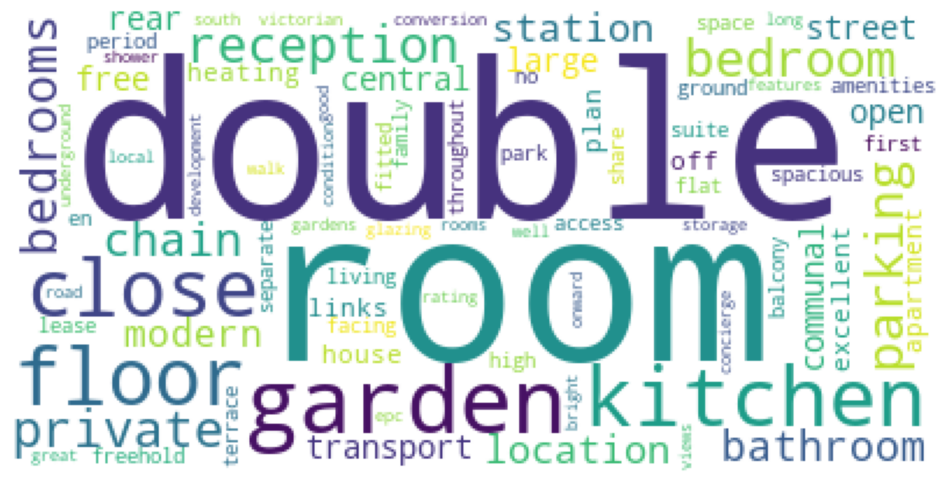

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))
# Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(doc_df.sum()) #using doc_df frequency
Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(fd) #using tf_idf
plt.imshow(Cloud) 
plt.axis("off");

### 3.3 Sublevel classification: garden, parking, kitchen, reception 

#### 3.3.1 Chain-free

In [51]:
# chain free 
df_cleaned['chain_free'] = ""
df_cleaned.loc[df_cleaned['cleaned'].str.contains('chain free|no onward chain'),"chain_free"] = 1
df_cleaned.loc[~df_cleaned['cleaned'].str.contains('chain free|no onward chain'),"chain_free"] = 0
df_cleaned['chain_free'].value_counts()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0    90209
1    18872
Name: chain_free, dtype: int64

#### 3.3.2 share freehold 

In [52]:
## share freehold
df_cleaned['share_freehold'] = ""
df_cleaned.loc[df_cleaned['cleaned'].str.contains('share freehold'),"share_freehold"] = "1"
df_cleaned.loc[~df_cleaned['cleaned'].str.contains('share freehold'),"share_freehold"] = "0"
df_cleaned['share_freehold'].value_counts()

0    99772
1    9309 
Name: share_freehold, dtype: int64

#### 3.3.3 en-suite 

In [53]:
## en-suite 

df_cleaned['en_suite'] = ""
df_cleaned.loc[df_cleaned['cleaned'].str.contains('en suite'),"en_suite"] = "1"
df_cleaned.loc[~df_cleaned['cleaned'].str.contains('en suite'),"en_suite"] = "0"
df_cleaned['en_suite'].value_counts()

0    101553
1    7528  
Name: en_suite, dtype: int64

#### 3.3.4 ground floor

In [54]:
# variables -  transport link,reception, bedroom
## ground floor

df_cleaned['ground_floor'] = ""
df_cleaned.loc[df_cleaned['cleaned'].str.contains('ground floor|first floor'),"ground_floor"] = "1"
df_cleaned.loc[~df_cleaned['cleaned'].str.contains('ground floor|first floor'),"ground_floor"] = "0"
df_cleaned['ground_floor'].value_counts()

0    93052
1    16029
Name: ground_floor, dtype: int64

#### 3.3.5 central heating

In [55]:
## central heating
df_cleaned['central_heating'] = ""
df_cleaned.loc[df_cleaned['cleaned'].str.contains('central heating'),"central_heating"] = "1"
df_cleaned.loc[~df_cleaned['cleaned'].str.contains('central heating'),"central_heating"] = "0"
df_cleaned['central_heating'].value_counts()

0    99957
1    9124 
Name: central_heating, dtype: int64

#### 3.3.6 transport link


In [56]:
## transport 

#transport link, location, station, close, local amenities
df_cleaned['good_location'] = ""
df_cleaned.loc[df_cleaned['cleaned'].str.contains('transport|location|station|close|local amenities'),"good_location"] = "1"
df_cleaned.loc[~df_cleaned['cleaned'].str.contains('transport|location|station|close|local amenities'),"good_location"] = "0"
df_cleaned['good_location'].value_counts()

0    55355
1    53726
Name: good_location, dtype: int64

#### 3.3.7 double bedroom

In [57]:
# double bedroom
df_cleaned['double_bedroom'] = ""
df_cleaned.loc[df_cleaned['cleaned'].str.contains('double bedroom'),"double_bedroom"] = "1"
df_cleaned.loc[~df_cleaned['cleaned'].str.contains('double bedroom'),"double_bedroom"] = "0"
df_cleaned['double_bedroom'].value_counts()

0    81698
1    27383
Name: double_bedroom, dtype: int64

#### 3.3.8 Get Garden Variables

##### extract garden description

In [58]:
def description_garden(x):
#     if 'garden' in x: 
    if 'garden' in x or 'gardens' in x: #check if bullets contains garden
        rule= re.search('^garden*', x)
        if (rule==None):
#             new_string = x.split("garden",1)[0]+' garden' 
            new_string = x.split("garden",1)[0] 
            new_text = ''.join(new_string)  
            text=new_text.split(",")[-1]           
            return text


In [59]:
# SettingwithCopyWarning?
# pd.options.mode.chained_assignment = "warn"
df_cleaned['garden_description'] =df_cleaned['cleaned'].map( lambda x: description_garden(x))
# df_cleaned['garden_description']

In [60]:
# caculate the word frequency - CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,3))
vectorizer.fit(df_cleaned)

tcorpus = vectorizer.transform(df_cleaned)
tcorpus # tcorpus for transformed corpus

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [61]:
df_cleaned.sample(2)

listing_id  \
50188  56360719     
40633  54100037     

                                                                       cleaned  \
50188  double bedroom apartment,reception room,modern kitchen,communal garden,   
40633  spacious double bedrooms,master bedroom en suite,great size living room   

      chain_free share_freehold en_suite ground_floor central_heating  \
50188  0          0              0        0            0                
40633  0          0              1        0            0                

      good_location double_bedroom garden_description  
50188  0             1              communal           
40633  0             1              None

In [62]:
# garden=df[df['cleaned'].str.contains('garden' or 'gardens')]
# garden['garden_description'] =garden['cleaned'].map( lambda x: description(x))

In [63]:
# find out all description about garden
garden =[x for x in ' '.join(corpus).split(',') if re.search('garden',x)]
len(garden)

47398

In [64]:
#clean the garden description, all words after the garden will be removed, "garden" is kept
garden_cleaned=[]
for x in garden:
    rule= re.search('^garden*', x)
    if (rule==None):
        new_string = x.split("garden",1)[0]+'garden' 
        new_text = ''.join(new_string)  
        new_text=new_text.replace('garden', '') #exclude garden
        garden_cleaned.append(new_text)
    else:
        new_string = x
        new_text = ''.join(new_string)  
        new_text=new_text.replace('garden', '') #if exlude garden
        garden_cleaned.append(new_text)
   
        
garden_cleaned[1:10]

['lake skyline views communal ',
 'almost acre wonderful landscaped communal ',
 'landscaped ',
 'communal ',
 'communal ',
 'residents exclusive ',
 'communal ',
 'steps away residents ',
 'private patio ']

#####  word frequency and visualization (TF-IDF)

In [65]:
# caculate the word frequency - CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,5))
vectorizer.fit(garden_cleaned)

tcorpus = vectorizer.transform(garden_cleaned)
tcorpus # tcorpus for transformed corpus

<47398x44173 sparse matrix of type '<class 'numpy.int64'>'
	with 198687 stored elements in Compressed Sparse Row format>

In [66]:
#create the dataframe
doc_df = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
doc_df_sum=doc_df.sum().to_frame(name="count").reset_index().rename(columns={'index':'description'})

In [67]:
#check the frequency
print(doc_df.shape)
doc_df.sum().sort_values(ascending=False).head(50)
# there are 3314 words, then we can try to group/cluster them according to sentiment/word-embedding 


(47398, 44173)


private                 13159
communal                10659
rear                    10388
facing                  6302 
south                   4397 
large                   3401 
south facing            3337 
west                    2385 
west facing             2325 
private rear            2265 
landscaped              1870 
access                  1619 
front                   1606 
patio                   1451 
front rear              913  
facing rear             849  
south west              738  
south west facing       714  
well                    711  
large private           681  
shared                  665  
beautiful               647  
direct                  615  
large rear              591  
secluded                587  
room                    586  
direct access           574  
bedroom                 547  
section                 518  
mature                  513  
lovely                  507  
courtyard               477  
access communal         467  
private so

In [68]:
## option 2: TF_IDF to count frequency
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), max_df=0.99, min_df=0.01)
tcorpus_tfidf    = vectorizer.fit_transform(garden_cleaned)

In [69]:
#create dataframe 
tfidf = pd.DataFrame(data=tcorpus_tfidf.toarray(),
                        columns=vectorizer.get_feature_names())

In [70]:
print(tfidf.sum().sort_values(ascending=False)) 
print(tfidf.shape)
#when garden included: 52 columns remained for ngram_range=(1,5), 29 columns remained for ngram_range=(2,5) 
#when garden excluded: 35 columns for ngram_range=(1,3)

private             9,743.595130517584 
communal            9,584.204512516193 
rear                6,617.81048615073  
facing              2,982.7311583963074
large               2,429.602416699775 
south               2,270.175388362728 
south facing        1,930.0294202878881
private rear        1,664.45098881729  
landscaped          1,594.58704055253  
patio               1,275.3438134155265
west                1,238.7352993490274
west facing         1,202.5802843146257
front               1,180.9840229578836
access              1,165.7063669847767
well                625.8174126251824  
front rear          622.0389118005282  
shared              596.2669065317303  
beautiful           543.3073866331401  
facing rear         508.9103079469254  
secluded            502.5430987719992  
large private       501.22972219806064 
bedroom             500.29875444085127 
room                479.6227629825273  
section             464.48564891452696 
large rear          451.6082190895418  


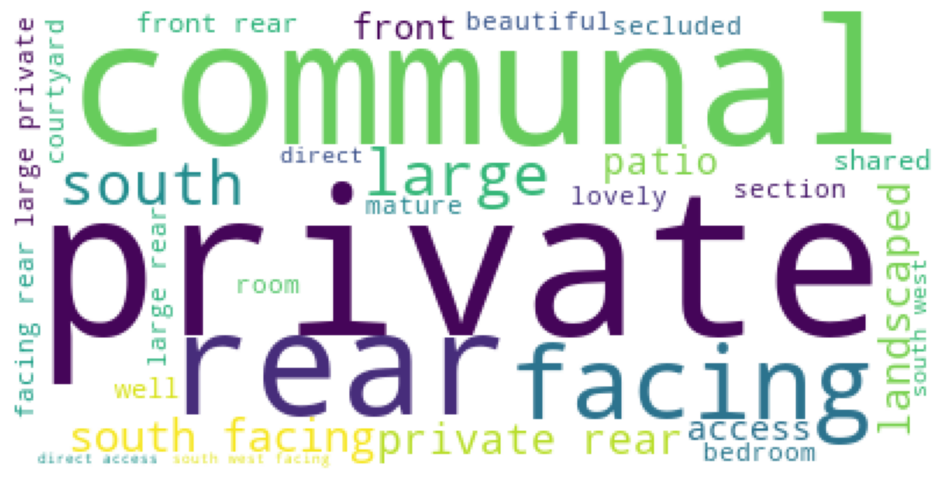

In [71]:
#visualize the description frequency with WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))
# Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(doc_df.sum()) #using doc_df frequency
Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(tfidf.sum().head(30)) #using tf_idf
plt.imshow(Cloud) 
plt.axis("off");

#####  creating dummy variables related to garden

according to the results of groups, creating dummy variables 

In [72]:
df_cleaned.head(2)

listing_id                                                      cleaned  \
0  47727957    ,year lease,east views,hour concierge service,zone location   
1  58128970    ,central heating,                                             

  chain_free share_freehold en_suite ground_floor central_heating  \
0  0          0              0        0            0                
1  0          0              0        0            1                

  good_location double_bedroom garden_description  
0  1             0              None               
1  0             0              None

In [73]:
#remove null value
df_cleaned['garden_description']=df_cleaned['garden_description'].fillna('no garden')
df_cleaned.head(1)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


listing_id                                                      cleaned  \
0  47727957    ,year lease,east views,hour concierge service,zone location   

  chain_free share_freehold en_suite ground_floor central_heating  \
0  0          0              0        0            0                

  good_location double_bedroom garden_description  
0  1             0              no garden

In [74]:
#assign 1 or 0 for variables 

#communal 
df_cleaned['garden_ownership_communal'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('communal|shared'),"garden_ownership_communal"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('communal|shared'),"garden_ownership_communal"] = 0

df_cleaned['garden_ownership_communal'].value_counts()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0    98207
1    10874
Name: garden_ownership_communal, dtype: int64

In [75]:
#private
df_cleaned['garden_ownership_private'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('private'),"garden_ownership_private"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('private'),"garden_ownership_private"] = 0

df_cleaned['garden_ownership_private'].value_counts()

0    96570
1    12511
Name: garden_ownership_private, dtype: int64

In [76]:
#front
df_cleaned['garden_type_front'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('front'),"garden_type_front"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('front'),"garden_type_front"] = 0

df_cleaned['garden_type_front'].value_counts()

0    107718
1    1363  
Name: garden_type_front, dtype: int64

In [77]:
#rear
df_cleaned['garden_type_rear'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('rear'),"garden_type_rear"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('rear'),"garden_type_rear"] = 0

df_cleaned['garden_type_rear'].value_counts()

0    99550
1    9531 
Name: garden_type_rear, dtype: int64

In [78]:
#patio
df_cleaned['garden_type_patio'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('patio'),"garden_type_patio"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('patio'),"garden_type_patio"] = 0

df_cleaned['garden_type_patio'].value_counts()

0    107753
1    1328  
Name: garden_type_patio, dtype: int64

In [79]:
# "Courtyard"
df_cleaned['garden_type_courtyard'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('courtyard'),"garden_type_courtyard"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('courtyard'),"garden_type_courtyard"] = 0

df_cleaned['garden_type_courtyard'].value_counts()

0    108619
1    462   
Name: garden_type_courtyard, dtype: int64

In [80]:
#orientation
#south｜west/facing
df_cleaned['garden_orientation'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('south|west|facing'),"garden_orientation"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('south|west|facing'),"garden_orientation"] = 0

df_cleaned['garden_orientation'].value_counts()

0    102840
1    6241  
Name: garden_orientation, dtype: int64

In [81]:
# Positive descriptive adjectives related to garden
## Large| Beautiful | stunning | Landscaped| Mature| Well | lovely| scheduled|section
df_cleaned['garden_positive'] = ""
df_cleaned.loc[df_cleaned['garden_description'].str.contains('large|beautiful|stunning|landscaped|mature|well|lovely|secluded|section'),"garden_positive"] = 1
df_cleaned.loc[~df_cleaned['garden_description'].str.contains('large|beautiful|stunning|landscaped|mature|well|lovely|secluded|section'),"garden_positive"] = 0

df_cleaned['garden_positive'].value_counts()

0    100828
1    8253  
Name: garden_positive, dtype: int64

In [82]:
df_cleaned.columns

Index(['listing_id', 'cleaned', 'chain_free', 'share_freehold', 'en_suite',
       'ground_floor', 'central_heating', 'good_location', 'double_bedroom',
       'garden_description', 'garden_ownership_communal',
       'garden_ownership_private', 'garden_type_front', 'garden_type_rear',
       'garden_type_patio', 'garden_type_courtyard', 'garden_orientation',
       'garden_positive'],
      dtype='object')

#### 3.3.9 Parking

##### extract parking description

In [83]:
## extract desxription about parking
# extract description of (garden/bedroom/parking/kitcken)
def description_parking(x):
    if 'parking' in x or 'parkings' in x:
        rule= re.search('^parking*', i)
        if (rule==None):
#             new_string = x.split("parking",1)[0]+'parking' 
            new_string = x.split("parking",1)[0] 
            new_text = ''.join(new_string)  
            text=new_text.split(",")[-1]
            return text

In [84]:
df_cleaned['parking_description'] =df['cleaned'].map( lambda x: description_parking(x))

In [85]:
# find out all description about parking
parking =[x for x in ' '.join(corpus).split(',') if re.search('parking',x)]
len(parking)

26851

In [86]:
#clean theparking description, all words after the parking will be removed, "parking" is kept
parking_cleaned=[]
for x in parking:
    rule= re.search('^parking*', x)
    if (rule==None):
        new_string = x.split("parking",1)[0]+'parking' 
        new_text = ''.join(new_string)  
#         new_text=new_text.replace('parking', '') #exclude parking
        parking_cleaned.append(new_text)
    else:
        new_string = x
        new_text = ''.join(new_string)  
#         new_text=new_text.replace('parking', '') #if exlude parking
        parking_cleaned.append(new_text)
   
        
parking_cleaned[1:10]

['underground parking',
 'private underground parking',
 'gated parking',
 'sqft sqm secure parking',
 'allocated parking',
 'secure underground parking',
 'underground parking',
 'underground parking',
 'parking available separate negotiation']

#####  TF_IDF frequency

In [87]:
## TF_IDF to count frequency
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,5), max_df=0.99, min_df=0.01)
tcorpus_tfidf    = vectorizer.fit_transform(parking_cleaned)

In [88]:
#create dataframe 
tfidf = pd.DataFrame(data=tcorpus_tfidf.toarray(),
                        columns=vectorizer.get_feature_names())

In [89]:
#check frequency 
print(tfidf.sum().sort_values(ascending=False).head(30)) 
print(tfidf.shape)

#parking get 18 words 

street                       4,600.2180595845875
street parking               4,578.425459549525 
off                          4,457.499839235615 
off street                   4,446.9583630422285
off street parking           4,431.688263382952 
allocated                    2,504.553810671747 
allocated parking            2,355.370453527368 
underground                  1,856.7542141148033
underground parking          1,797.0569736477623
secure                       1,385.3248592535572
private                      1,089.2949009442486
residents                    935.2634473481412  
private parking              850.0109719811911  
residents parking            839.5890045870673  
streetresidents parking      720.9185579677354  
streetresidents              720.9185579677354  
secure parking               708.5380723459655  
secure underground           512.4244992286682  
secure underground parking   497.03002218388906 
gated                        496.9098560126218  
garage              

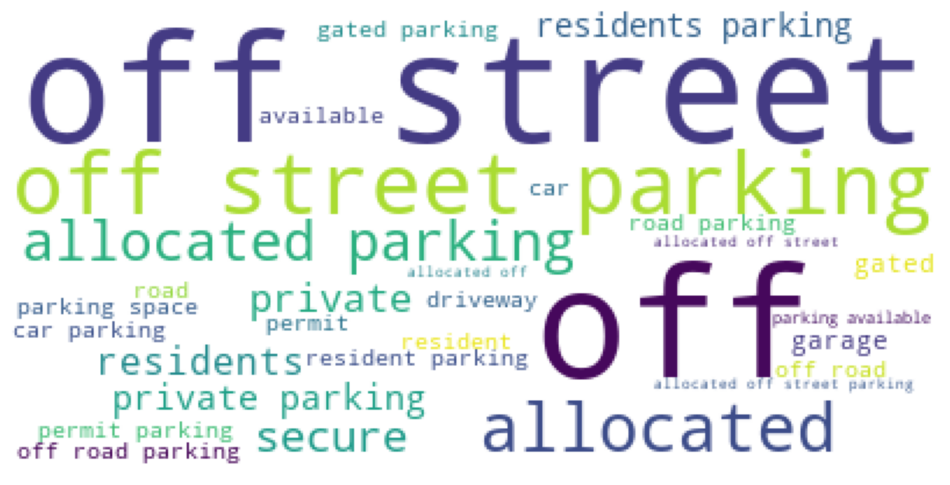

In [90]:
#visualize the description frequency with WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))
# Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(doc_df.sum()) #using doc_df frequency
Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(tfidf.sum().head(30)) #using tf_idf
plt.imshow(Cloud) 
plt.axis("off");

##### Dividing the top 30 words into groups 

##### creating dummy variables related to parking

according to the results of groups, creating dummy variables 

In [91]:
#remove null value
df_cleaned['parking_description']=df_cleaned['parking_description'].fillna('no parking')
df_cleaned.head(1)

listing_id                                                      cleaned  \
0  47727957    ,year lease,east views,hour concierge service,zone location   

  chain_free share_freehold en_suite ground_floor central_heating  \
0  0          0              0        0            0                

  good_location double_bedroom garden_description garden_ownership_communal  \
0  1             0              no garden          0                          

  garden_ownership_private garden_type_front garden_type_rear  \
0  0                        0                 0                 

  garden_type_patio garden_type_courtyard garden_orientation garden_positive  \
0  0                 0                     0                  0                

  parking_description  
0  no parking

In [92]:
#assign 1 or 0 for variables 

#street parking/resident parking  
df_cleaned['parking_street'] = ""
df_cleaned.loc[df_cleaned['parking_description'].str.contains('^street|road|streetresidents|resident|residents'),"parking_street"] = 1
df_cleaned.loc[~df_cleaned['parking_description'].str.contains('^street|road|streetresidents|resident|residents'),"parking_street"] = 0

df_cleaned['parking_street'].value_counts()


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0    105305
1    3776  
Name: parking_street, dtype: int64

In [93]:
#assign 1 or 0 for variables 

#off street parking
#underground|garage|off street
df_cleaned['parking_off_street'] = ""
df_cleaned.loc[df_cleaned['parking_description'].str.contains('underground|garage|off street|private|allocated|secure|gated'),"parking_off_street"] = 1
df_cleaned.loc[~df_cleaned['parking_description'].str.contains('underground|garage|off street|private|allocated|secure|gated'),"parking_off_street"] = 0

df_cleaned['parking_off_street'].value_counts()

0    89351
1    19730
Name: parking_off_street, dtype: int64

#### 3.3.10 reception

In [94]:
def description_reception(x):
#     if 'reception' in x: 
    if 'reception' in x: #check if bullets contains transport
        rule= re.search('^reception*', x)
        if (rule==None):
            new_string = x.split("reception",1)[0]+'reception' 
#             new_string = x.split("transport",1)[0] 
            new_text = ''.join(new_string)  
            text=new_text.split(",")[-1]           
            return text
        else:
            new_string = x
            new_text = ''.join(new_string) 
            text=new_text.split(",")[0]           
            return text
            


In [95]:
# SettingwithCopyWarning?
# pd.options.mode.chained_assignment = "warn"
df_cleaned['reception_description'] =df_cleaned['cleaned'].map( lambda x: description_reception(x))
# df_cleaned['reception_description']

In [96]:

# find out all description about transport
reception =[x for x in ' '.join(corpus).split(',') if re.search('reception',x)]
print(len(reception))

#clean the garden description, all words after the garden will be removed, "garden" is kept
reception_cleaned=[]
for x in reception:
    rule= re.search('^reception', x)
    if (rule==None):
        new_string = x.split("reception",1)[0]+'reception' 
        new_text = ''.join(new_string)  
        new_text=new_text.replace('reception', '') #exclude reception
        reception_cleaned.append(new_text)
    else:
        new_string = x
        new_text = ''.join(new_string)  
        new_text=new_text.replace('reception', '') #if exlude reception
        reception_cleaned.append(new_text)
   
        
reception_cleaned[1:10]
# reception_cleaned

30464


['open plan kitchen',
 ' room access balcony',
 ' room',
 ' room',
 ' room',
 'open plan ',
 'west facing ',
 ' room',
 'dual aspect ']

##### word frequency and visualization (TF-IDF)

In [97]:
# caculate the word frequency - CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,5))
vectorizer.fit(reception_cleaned)

tcorpus = vectorizer.transform(reception_cleaned)
tcorpus # tcorpus for transformed corpus

<30464x17441 sparse matrix of type '<class 'numpy.int64'>'
	with 87515 stored elements in Compressed Sparse Row format>

In [98]:
#create the dataframe
doc_df = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
doc_df_sum=doc_df.sum().to_frame(name="count").reset_index().rename(columns={'index':'description'})

In [99]:
#check the frequency
print(doc_df.shape)
doc_df.sum().sort_values(ascending=False).head(30)
# there are 3314 words, then we can try to group/cluster them according to sentiment/word-embedding 

(30464, 17441)


room                 7529
rooms                4800
open                 3823
plan                 3701
open plan            3693
spacious             2956
large                2808
double               2632
kitchen              2183
bright               1465
plan kitchen         1451
open plan kitchen    1448
separate             697 
bright spacious      546 
aspect               505 
dining               464 
facing               413 
front                367 
light                338 
dining room          334 
bay                  330 
generous             325 
dual                 318 
dual aspect          307 
south                281 
stunning             266 
south facing         244 
large open           232 
spacious open        228 
large open plan      227 
dtype: int64

In [100]:
## option 2: TF_IDF to count frequency
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), max_df=0.99, min_df=0.01)
tcorpus_tfidf    = vectorizer.fit_transform(reception_cleaned)

In [101]:
#create dataframe 
tfidf = pd.DataFrame(data=tcorpus_tfidf.toarray(),
                        columns=vectorizer.get_feature_names())

In [102]:
print(tfidf.sum().sort_values(ascending=False).head(30)) 
print(tfidf.shape)
#when garden included: 52 columns remained for ngram_range=(1,5), 29 columns remained for ngram_range=(2,5) 
#when garden excluded: 35 columns for ngram_range=(1,3)

room                7,081.894610583434 
rooms               4,774.018343360861 
large               2,557.524299410165 
double              2,446.253788415863 
spacious            2,401.812785758707 
open                1,813.4556554688745
plan                1,735.503993389061 
open plan           1,731.874473790053 
kitchen             1,189.4782955870303
bright              1,095.4265006386051
plan kitchen        668.9449922969399  
open plan kitchen   667.349279135982   
separate            627.6237731396119  
facing              390.23569377810287 
bright spacious     354.0664130843854  
dining              320.07628986937476 
front               319.66518838028    
aspect              308.23411253676596 
bay                 306.5326783215621  
generous            302.6161798807327  
light               287.9553338377504  
dining room         226.06894300226756 
dual                181.79395715961866 
dual aspect         172.96707870322038 
dtype: float64
(30464, 24)


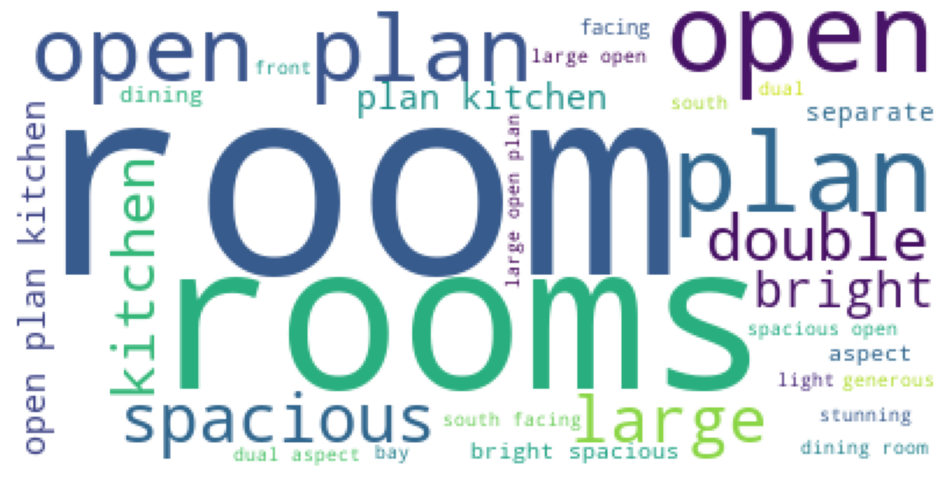

In [103]:
#visualize the description frequency with WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))
Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(doc_df.sum().sort_values(ascending=False).head(30)) #using doc_df frequency
# Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(tfidf.sum()) #using tf_idf
plt.imshow(Cloud) 
plt.axis("off");

##### Dividing the top 30 words into groups 

Manully divide the variables into several groups

####  3.3.11 Reception

according to the results of groups, creating dummy variables 

In [104]:
#remove null value
df_cleaned['reception_description']=df_cleaned['reception_description'].fillna('no reception description')
df_cleaned.head(1)

listing_id                                                      cleaned  \
0  47727957    ,year lease,east views,hour concierge service,zone location   

  chain_free share_freehold en_suite ground_floor central_heating  \
0  0          0              0        0            0                

  good_location double_bedroom garden_description  ... garden_type_front  \
0  1             0              no garden          ...  0                  

  garden_type_rear garden_type_patio garden_type_courtyard garden_orientation  \
0  0                0                 0                     0                   

  garden_positive parking_description parking_street parking_off_street  \
0  0               no parking          0              0                   

      reception_description  
0  no reception description  

[1 rows x 22 columns]

In [105]:
#assign 1 or 0 for variables 

#positive
#spacious|large|stunning|generous|double|bright|light|dual|aspect    
df_cleaned['reception_positive'] = ""
df_cleaned.loc[df_cleaned['reception_description'].str.contains('spacious|large|stunning|generous|double|bright|light|dual|aspect|bay|front|fronted'),"reception_positive"] = 1
df_cleaned.loc[~df_cleaned['reception_description'].str.contains('spacious|large|stunning|generous|double|bright|light|dual|aspect|bay|front|fronted'),"reception_positive"]  = 0

df_cleaned['reception_positive'].value_counts()

0    98846
1    10235
Name: reception_positive, dtype: int64

In [106]:
#reception_orientation
#South|facing   
df_cleaned['reception_orientation'] = ""
df_cleaned.loc[df_cleaned['reception_description'].str.contains('south|facing'),"reception_orientation"] = 1
df_cleaned.loc[~df_cleaned['reception_description'].str.contains('south|facing'),"reception_orientation"]   = 0

df_cleaned['reception_orientation'].value_counts()

0    108727
1    354   
Name: reception_orientation, dtype: int64

In [107]:
#open plan|kitchen|dining   
df_cleaned['reception_open'] = ""
df_cleaned.loc[df_cleaned['reception_description'].str.contains('open plan|kitchen|dining'),"reception_open"] = 1
df_cleaned.loc[~df_cleaned['reception_description'].str.contains('open plan|kitchen|dining'),"reception_open"] = 0

df_cleaned['reception_open'].value_counts()

0    104772
1    4309  
Name: reception_open, dtype: int64

In [108]:
#separate    
df_cleaned['reception_separate'] = ""
df_cleaned.loc[df_cleaned['reception_description'].str.contains('separate'),"reception_separate"] = 1
df_cleaned.loc[~df_cleaned['reception_description'].str.contains('separate'),"reception_separate"]  = 0

df_cleaned['reception_separate'].value_counts()

0    108454
1    627   
Name: reception_separate, dtype: int64

#### 3.3.12 Kitchen

In [109]:
## extract desxription about kitchen
# extract description of (garden/bedroom/parking/kitchen)
def description_kitchen(x):
    if 'kitchens' in x or 'kitchen' in x:
        rule= re.search('^kitchen*', i)
        if (rule==None):
#             new_string = x.split("kitchen",1)[0]+'kitchen' 
            new_string = x.split("kitchen",1)[0] 
            new_text = ''.join(new_string)  
            text=new_text.split(",")[-1]
            return text

In [110]:
df_cleaned['kitchen_description'] =df['cleaned'].map( lambda x: description_kitchen(x))

In [111]:
# find out all description about parking
kitchen =[x for x in ' '.join(corpus).split(',') if re.search('kitchen',x)]
len(parking)

26851

In [112]:
#clean theparking description, all words after the parking will be removed, "parking" is kept
kitchen_cleaned=[]
for x in kitchen:
    rule= re.search('^kitchen*', x)
    if (rule==None):
        new_string = x.split("kitchen",1)[0]+'kitchen' 
        new_text = ''.join(new_string)  
        new_text=new_text.replace('kitchen', '') #exclude kitchen
        kitchen_cleaned.append(new_text)
    else:
        new_string = x
        new_text = ''.join(new_string)  
        new_text=new_text.replace('kitchen', '') #if exlude kitchen
        kitchen_cleaned.append(new_text)
   
        
kitchen_cleaned[1:10]

['fitted ',
 'fully fitted ',
 'original ',
 'thomson brothers contemporary ',
 'open plan ',
 'open plan ',
 'refurbished ',
 'fitted ',
 'fully equipped ']

In [113]:
## option 2: TF_IDF to count frequency
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,5), max_df=0.99, min_df=0.01)
tcorpus_tfidf    = vectorizer.fit_transform(kitchen_cleaned)

In [114]:
#create dataframe 
tfidf = pd.DataFrame(data=tcorpus_tfidf.toarray(),
                        columns=vectorizer.get_feature_names())

In [115]:
#check frequency 
print(tfidf.sum().sort_values(ascending=False).head(30)) 
print(tfidf.shape)


fitted           6,483.620998442528 
modern           4,665.683774626614 
separate         4,335.466853910399 
open             3,634.326092301788 
plan             3,539.252998856521 
open plan        3,519.968678745047 
room             2,369.847450527543 
large            1,510.5187198487713
eat              1,428.4194710788568
breakfast        1,303.1203423849113
fully            1,268.4629328047556
breakfast room   1,236.0446216823725
modern fitted    1,083.426999206729 
fully fitted     1,045.1470725674442
extended         969.4406019117304  
integrated       945.6824300532888  
reception        945.1914035919849  
dining           922.9636587385352  
spacious         895.9440163782767  
diner            806.4248257605094  
dining room      704.5819584514753  
contemporary     683.6140383549894  
well             529.7943499144151  
stylish          513.1365936403116  
new              496.6836992231393  
equipped         492.27436770629976 
bespoke          474.80483583411893 
s

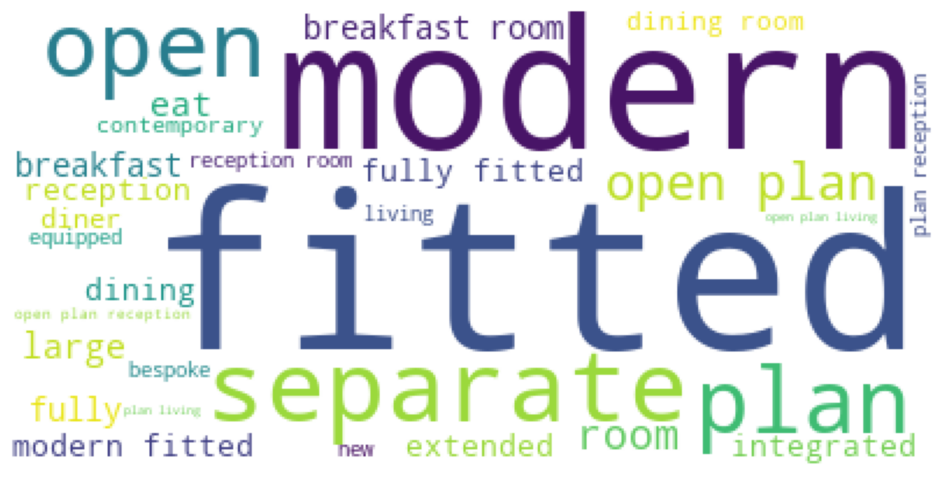

In [116]:
#visualize the description frequency with WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))
# Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(doc_df.sum()) #using doc_df frequency
Cloud = WordCloud(background_color="white", max_words=80).generate_from_frequencies(tfidf.sum().head(30)) #using tf_idf
plt.imshow(Cloud) 
plt.axis("off");

##### creating dummy variables related to KITCHEN

according to the results of groups, creating dummy variables 

In [117]:
#remove null value
df_cleaned['kitchen_description']=df_cleaned['kitchen_description'].fillna('no kitchen')
df_cleaned.head(1)

listing_id                                                      cleaned  \
0  47727957    ,year lease,east views,hour concierge service,zone location   

  chain_free share_freehold en_suite ground_floor central_heating  \
0  0          0              0        0            0                

  good_location double_bedroom garden_description  ... garden_positive  \
0  1             0              no garden          ...  0                

  parking_description parking_street parking_off_street  \
0  no parking          0              0                   

      reception_description reception_positive reception_orientation  \
0  no reception description  0                  0                      

  reception_open reception_separate kitchen_description  
0  0              0                  no kitchen          

[1 rows x 27 columns]

In [118]:
#assign 1 or 0 for variables 
#kitchen_positive
#fitted|modern|large|fully|spacious|contemporary|well|stylish|equipped|new|stunning|integrated     
df_cleaned['kitchen_positive'] = ""
df_cleaned.loc[df_cleaned['kitchen_description'].str.contains('fitted|modern|large|fully|spacious|contemporary|well|stylish|equipped|new|stunning|integrated'),"kitchen_positive"] = 1
df_cleaned.loc[~df_cleaned['kitchen_description'].str.contains('fitted|modern|large|fully|spacious|contemporary|well|stylish|equipped|new|stunning|integrated'),"kitchen_positive"] = 0

df_cleaned['kitchen_positive'].value_counts()

0    90127
1    18954
Name: kitchen_positive, dtype: int64

In [119]:
#assign 1 or 0 for variables 

#open plan|living|reception|extened                                    
df_cleaned['kitchen_open'] = ""
df_cleaned.loc[df_cleaned['kitchen_description'].str.contains('open|plan|living|reception|extened'),"kitchen_open"] = 1
df_cleaned.loc[~df_cleaned['kitchen_description'].str.contains('open|plan|living|reception|extened'),"kitchen_open"] = 0

df_cleaned['kitchen_open'].value_counts()

0    101057
1    8024  
Name: kitchen_open, dtype: int64

In [120]:
#assign 1 or 0 for variables 

#separate                      
df_cleaned['kitchen_separate'] = ""
df_cleaned.loc[df_cleaned['kitchen_description'].str.contains('separate'),"kitchen_separate"] = 1
df_cleaned.loc[~df_cleaned['kitchen_description'].str.contains('separate'),"kitchen_separate"] = 0

df_cleaned['kitchen_separate'].value_counts()

0    104224
1    4857  
Name: kitchen_separate, dtype: int64

In [121]:
#assign 1 or 0 for variables 

#eat  /  breakfast  / diner / dining                          
df_cleaned['kitchen_diner'] = ""
df_cleaned.loc[df_cleaned['kitchen_description'].str.contains('eat|breakfast|diner|dining'),"kitchen_diner"] = 1
df_cleaned.loc[~df_cleaned['kitchen_description'].str.contains('eat|breakfast|diner|dining'),"kitchen_diner"] = 0

df_cleaned['kitchen_diner'].value_counts()

0    107002
1    2079  
Name: kitchen_diner, dtype: int64

## 4. Merge the dataset

In [122]:
df_dummy.columns

Index(['log_price_last', 'num_bed_last', 'num_floors_max', 'num_bath_max',
       'num_reception_max', 'property_type_End terrace house',
       'property_type_Flat', 'property_type_Studio',
       'property_type_Maisonette', 'property_type_Semi-detached house',
       'property_type_Detached house', 'property_type_Terraced house',
       'sub_regions_central', 'sub_regions_east', 'sub_regions_north',
       'sub_regions_south', 'sub_regions_west'],
      dtype='object')

In [232]:
df_text=pd.concat([df_dummy,df_cleaned],axis=1)
df_text.shape

(124470, 48)

In [233]:
df_text.dropna(inplace=True)

In [234]:
df_text=df_text.drop(columns=['listing_id', 'cleaned', 'garden_description','parking_description','kitchen_description',
                             'reception_description'])
print(df_text.shape)

(109081, 42)


In [235]:
df_text.columns

Index(['log_price_last', 'num_bed_last', 'num_floors_max', 'num_bath_max',
       'num_reception_max', 'property_type_End terrace house',
       'property_type_Flat', 'property_type_Studio',
       'property_type_Maisonette', 'property_type_Semi-detached house',
       'property_type_Detached house', 'property_type_Terraced house',
       'sub_regions_central', 'sub_regions_east', 'sub_regions_north',
       'sub_regions_south', 'sub_regions_west', 'chain_free', 'share_freehold',
       'en_suite', 'ground_floor', 'central_heating', 'good_location',
       'double_bedroom', 'garden_ownership_communal',
       'garden_ownership_private', 'garden_type_front', 'garden_type_rear',
       'garden_type_patio', 'garden_type_courtyard', 'garden_orientation',
       'garden_positive', 'parking_street', 'parking_off_street',
       'reception_positive', 'reception_orientation', 'reception_open',
       'reception_separate', 'kitchen_positive', 'kitchen_open',
       'kitchen_separate', 'kitchen_

In [236]:
#change data type from obj to floats
cols = ['chain_free', 'share_freehold',
       'en_suite', 'ground_floor', 'central_heating', 'good_location',
       'double_bedroom', 'garden_ownership_communal',
       'garden_ownership_private', 'garden_type_front', 'garden_type_rear',
       'garden_type_patio', 'garden_type_courtyard', 'garden_orientation',
       'garden_positive', 'parking_street', 'parking_off_street',
       'reception_positive', 'reception_orientation', 'reception_open',
       'reception_separate', 'kitchen_positive', 'kitchen_open',
       'kitchen_separate', 'kitchen_diner']
# df_text[cols] = df_text[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_text[cols]=df_text[cols].astype(str).astype(int)

In [237]:
# a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables.
# df_final=df_dummy.drop(['property_type_Retail premises','lad20nm_Ealing'],axis=1)

#for sample data, only choose 7 popular property types, and 4 housing characteristics  
df_notext=df_text[['log_price_last','num_bed_last', 'num_floors_max', 'num_bath_max','num_reception_max',
                   'property_type_End terrace house', 'property_type_Flat', 'property_type_Studio', 'property_type_Maisonette','property_type_Semi-detached house', 'property_type_Detached house','property_type_Terraced house',
                  'sub_regions_central', 'sub_regions_east', 'sub_regions_north','sub_regions_south', 'sub_regions_west']]
#let's check the number of columns and rows
df_notext.shape

(109081, 17)

In [238]:
df_text.shape

(109081, 42)

## 5. Regression 

### 5.1 regression without keywords

Text(0.5, 1.0, 'Correlation Matrix')

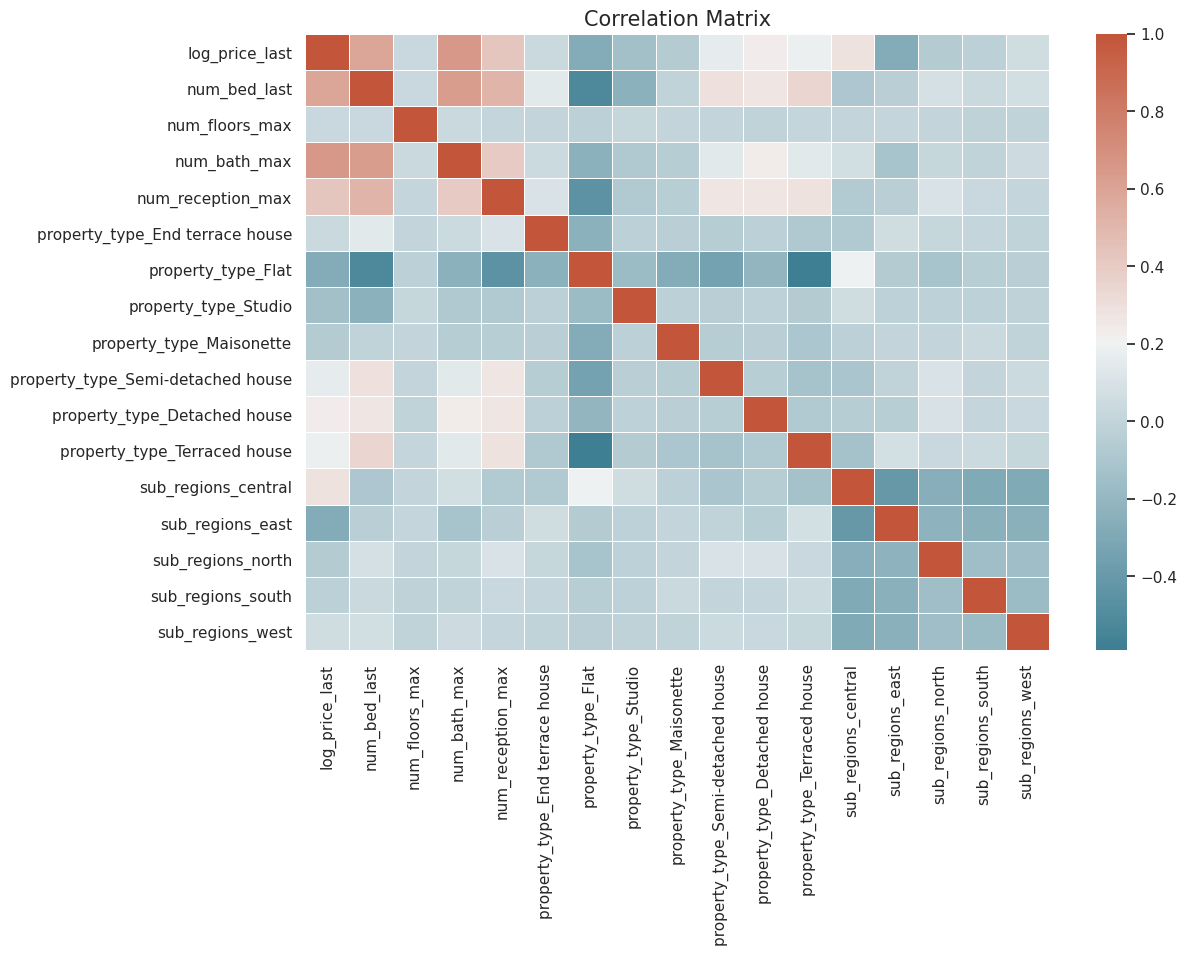

In [239]:
# correlation matrix 
#correlation plot 
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_notext.corr(), 
            cmap=sns.diverging_palette(220, 20, n=200),
            linewidths=.5, fmt= '.1f',ax=ax,
            annot=False)
ax.set_title('Correlation Matrix',fontsize=15)


In [240]:
# split the dependent and independent variables 
X = df_notext.drop(['log_price_last'], axis=1)
y = df_notext['log_price_last']


In [241]:
# We apply train_test_split twice to obtain the three train, dev and test sets
 #from the whole dataset, divide 70% data into train, 30% into test dataset
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=100) 

 #from the 30% test dataset, divide half data into val dataset
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1024) 

In [242]:
print('train_x ',train_x.shape)
print('train_y ',train_y.shape)
print('test_x',test_x.shape)
print('test_y',test_y.shape)

train_x  (76356, 16)
train_y  (76356,)
test_x (16363, 16)
test_y (16363,)


In [243]:
# Check for NaNs
y[y.isna()].index.values

array([], dtype=int64)

#### 5.1.1 Lasso Regression 

In [244]:
# increase the max_iter to guarantee convergence
lasso_model = sklearn.linear_model.Lasso(alpha=0.01, max_iter=10000, random_state=42)
lasso_model.fit(X=train_x, y=train_y)

# print(lasso_model.coef_)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
print(df_coef_lasso)

# using the model.score function to get the R2 on the train, val, and testing data
print('R2 of train: ',lasso_model.score(X=train_x, y=train_y))
# print('R2 of val: ',lasso_model.score(X=val_x, y=val_y))
print('R2 of test: ',lasso_model.score(X=test_x, y=test_y))

                                  var                  coef
0   num_bed_last                      0.16086445405290875  
1   num_floors_max                    0.0                  
2   num_bath_max                      0.268699888209288    
3   num_reception_max                 0.10329820976148303  
4   property_type_End terrace house   -0.0                 
5   property_type_Flat                -0.0                 
6   property_type_Studio              -0.0                 
7   property_type_Maisonette          -0.0                 
8   property_type_Semi-detached house 0.0                  
9   property_type_Detached house      0.0                  
10  property_type_Terraced house      0.0                  
11  sub_regions_central               0.3105515711286003   
12  sub_regions_east                  -0.135178800651721   
13  sub_regions_north                 -0.031040430799740375
14  sub_regions_south                 0.0                  
15  sub_regions_west                  0.

In [245]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = lasso_model.predict(train_x)
mse_train = mean_squared_error(train_y, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = lasso_model.predict(test_x)
mse_test =mean_squared_error(test_y, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 0.18
MSE test set 0.18


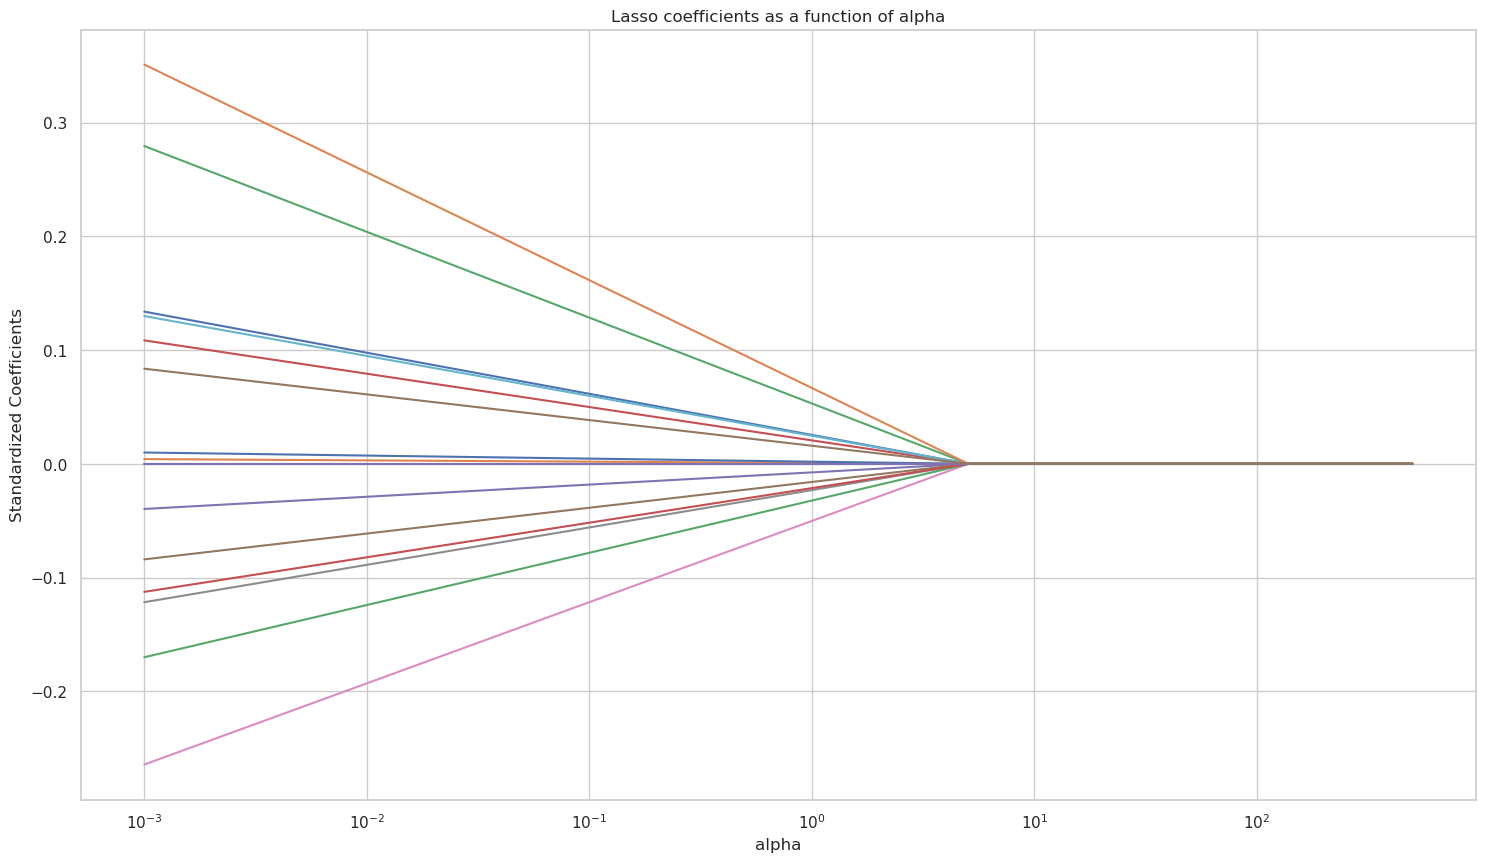

In [246]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = sklearn.linear_model.Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(train_x, train_y)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [247]:
#find the best alpha 
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=10,random_state=42, max_iter=10000).fit(train_x, train_y)
model.alpha_

0.0005072048893304779

In [248]:
# increase the max_iter to guarantee convergence
lasso_model = sklearn.linear_model.Lasso(alpha=model.alpha_, max_iter=10000, random_state=42)
lasso_model.fit(X=train_x, y=train_y)

# print(lasso_model.coef_)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
print(df_coef_lasso)

# using the model.score function to get the R2 on the train, val, and testing data
print('R2 of train: ',lasso_model.score(X=train_x, y=train_y))
# print('R2 of val: ',lasso_model.score(X=val_x, y=val_y))
print('R2 of test: ',lasso_model.score(X=test_x, y=test_y))

                                  var                 coef
0   num_bed_last                      0.12940881640494928 
1   num_floors_max                    0.005776752373261841
2   num_bath_max                      0.2808294104692144  
3   num_reception_max                 0.10674952835940081 
4   property_type_End terrace house   -0.06725321005352763
5   property_type_Flat                -0.10649100794486915
6   property_type_Studio              -0.3214122778053896 
7   property_type_Maisonette          -0.15143735496359545
8   property_type_Semi-detached house 0.0                 
9   property_type_Detached house      0.14004156926948005 
10  property_type_Terraced house      0.0                 
11  sub_regions_central               0.3540265202368656  
12  sub_regions_east                  -0.17226204305986673
13  sub_regions_north                 -0.11835014459066813
14  sub_regions_south                 0.0                 
15  sub_regions_west                  0.0868436100264233

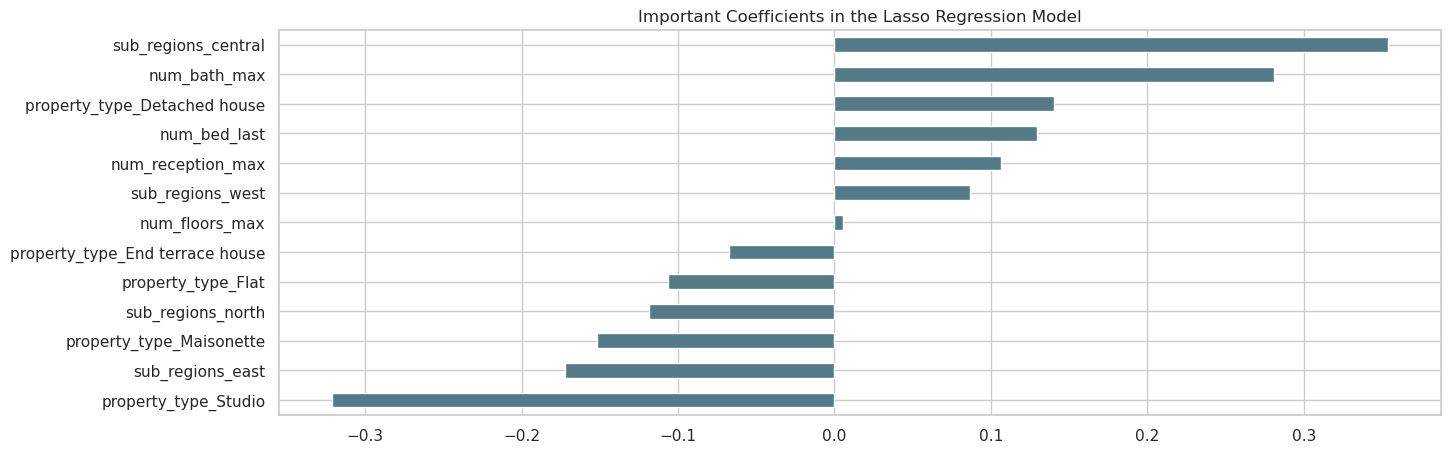

In [249]:
# Plot important coefficients
coefs = pd.Series(lasso_model.coef_, index = train_x.columns)
imp_coefs = pd.concat([coefs.sort_values().head(6),
                     coefs.sort_values().tail(7)])
plt.figure(figsize = (15, 5))
sns.set_style("whitegrid")
imp_coefs.plot(kind = "barh",color='#547987')
plt.title("Important Coefficients in the Lasso Regression Model")
plt.show()

(0.0003590735632205351,
 0.7164459489955293,
 0.14220038070284916,
 0.45702516431654255)

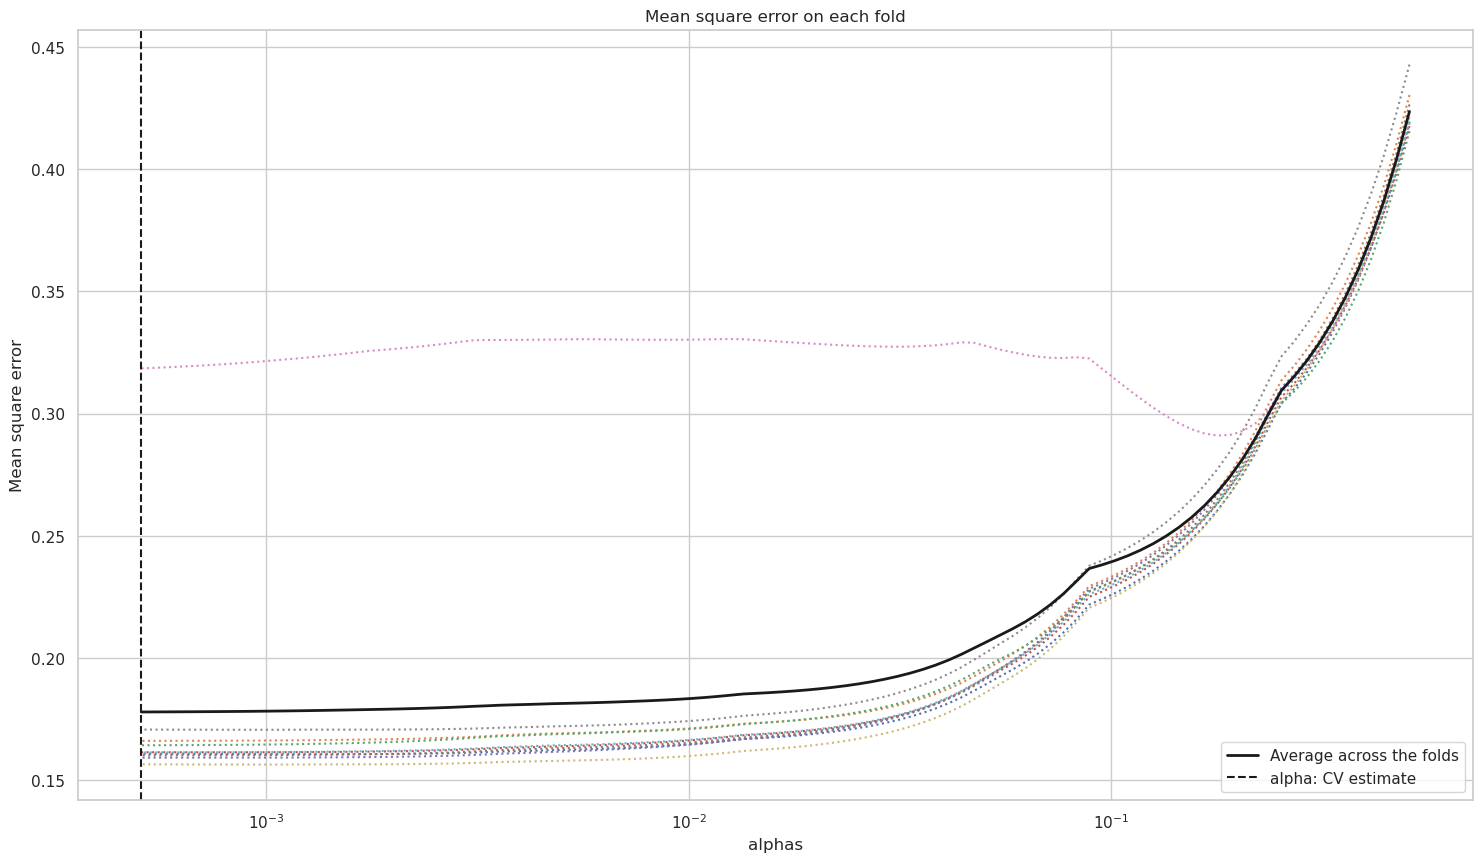

In [250]:
#evaluate the lasso 
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# ymin, ymax = 50000, 250000
# plt.ylim(ymin, ymax);

#### 5.1.2 GBDT

In [251]:
 #from the 30% test dataset, divide half data into val dataset
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1024) 

In [252]:
! pip install XGBoost
import xgboost as xgb

In [253]:
# set the random set for reproduce the same result
random_state_xgb = 43

In [254]:
%%time
xgb_model = xgb.XGBRegressor(random_state = random_state_xgb)
xgb_model.fit(train_x, train_y)

CPU times: user 16.6 s, sys: 115 ms, total: 16.7 s
Wall time: 2.17 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=43,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [255]:
#check the result by using default parameters 
print("R2 on the training data:")
print(xgb_model.score(X=train_x, y=train_y))

print("R2 on the testing data:")
print(xgb_model.score(X=test_x, y=test_y))

R2 on the training data:
0.6949883546117106
R2 on the testing data:
0.6864372324535257


In [256]:
#tuning the n_estimator and learning rates


parameters = {'n_estimators':[30,35,40],
              'learning_rate':[0.25,0.26,0.27],
              'max_depth':[3,4,5],
              'min_child_weight':range(1,6,2)
             }
xgb_model = xgb.XGBRegressor()

#cv=5 by default, which means 5-fold cross-validation
clf_xgb = model_selection.GridSearchCV(xgb_model, parameters)

clf_xgb.fit(val_x, val_y)

#we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf_xgb.best_params_)
print ("The best score is: ")
print (clf_xgb.best_score_)

The best parameter value is: 
{'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 40}
The best score is: 
0.6683376311694396


In [257]:
#running the xgb model again to get the optimal results (manully input the optimal hyperparameters) 

xgb_model_final = xgb.XGBRegressor(n_estimators=40,
                                   max_depth=5,
                                   learning_rate = 0.27,
                                   min_child_weight=3,
                                   random_state = random_state_xgb)

xgb_model_final.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.27, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=8, num_parallel_tree=1, random_state=43,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [258]:
print("R2 on the training data:")
print(xgb_model_final.score(X=train_x, y=train_y))
print("R2 on the val data:")
print(xgb_model_final.score(X=val_x, y=val_y))
print("R2 on the testing data:")
print(xgb_model_final.score(X=test_x, y=test_y))

R2 on the training data:
0.6824768070992229
R2 on the val data:
0.6718806709403944
R2 on the testing data:
0.6873510016117679


                                             Importance
num_bath_max                      0.4923168420791626   
sub_regions_central               0.1741327941417694   
sub_regions_east                  0.1074877381324768   
num_bed_last                      0.06995996087789536  
num_reception_max                 0.029383085668087006 
sub_regions_north                 0.024832122027873993 
property_type_Studio              0.021409794688224792 
sub_regions_west                  0.018621979281306267 
property_type_Detached house      0.016790911555290222 
property_type_Flat                0.010032468475401402 
property_type_Maisonette          0.00859212875366211  
property_type_Semi-detached house 0.007955998182296753 
property_type_Terraced house      0.007821068167686462 
property_type_End terrace house   0.0042367959395051   
sub_regions_south                 0.0037406727205961943


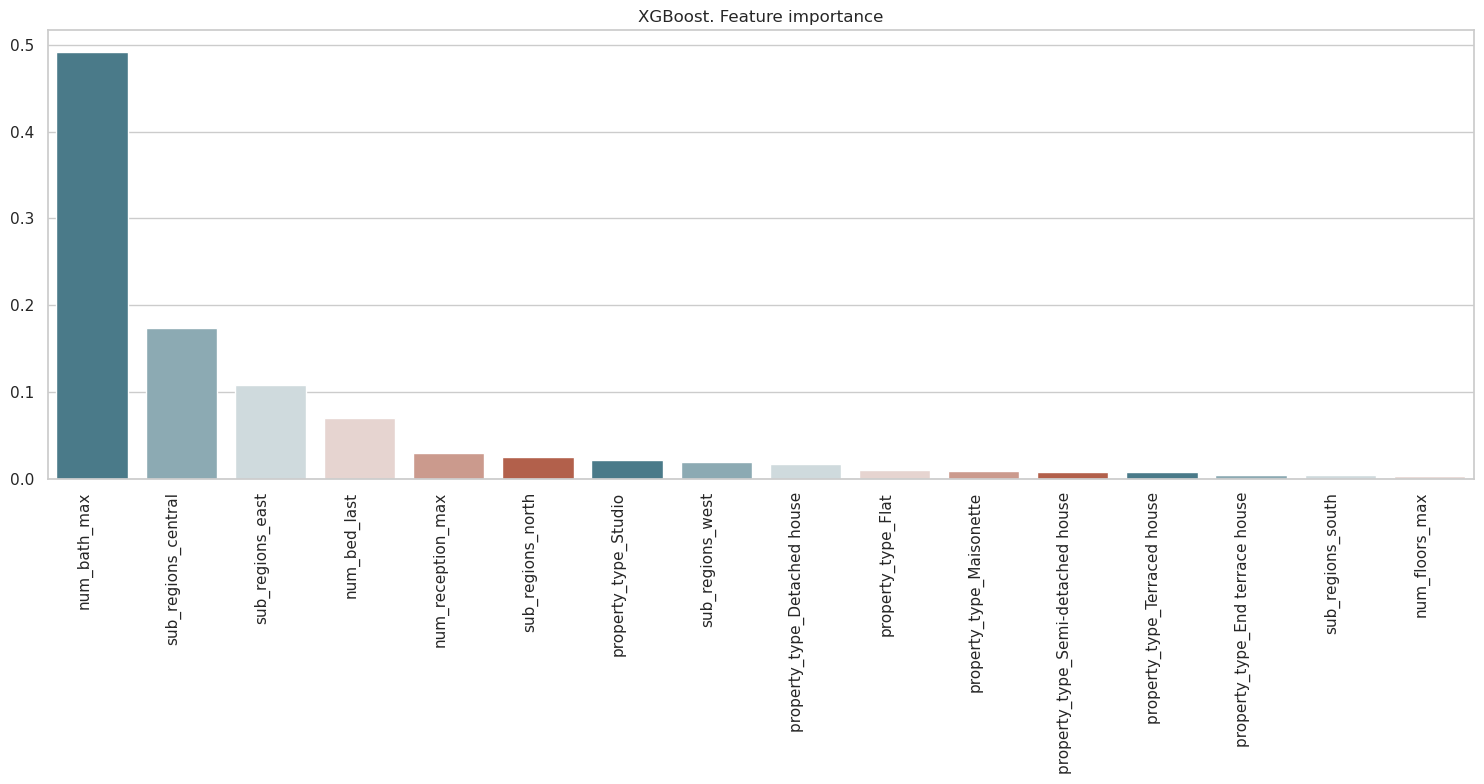

In [259]:
# Calculate feature importances
XGB_importances = xgb_model_final.feature_importances_
# Visualize Feature Importance
# Sort feature importances in descending order
XGB_indices = np.argsort(XGB_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
XGB_names = [train_x.columns[i] for i in XGB_indices]

#create dataframe for the importance of variables 
XGBoost_importance = pd.DataFrame(XGB_importances[XGB_indices],XGB_names,columns=['Importance'])

#print the most important features 
print(XGBoost_importance.head(15))

plt.figure(figsize = (15, 8))
sns.set_style("whitegrid")
chart = sns.barplot(x = XGB_names, y=XGB_importances[XGB_indices],palette=sns.diverging_palette(220, 20))
plt.xticks(rotation=90, horizontalalignment='right', fontweight='light')
plt.title('XGBoost. Feature importance')
plt.tight_layout()

### 5.2 Regression with Textual information

In [260]:
# split the dependent and independent variables 
X = df_text.drop(['log_price_last'], axis=1)
y = df_text['log_price_last']
# y=np.log(y)

In [261]:
# We apply train_test_split twice to obtain the three train, dev and test sets
 #from the whole dataset, divide 70% data into train, 30% into test dataset
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.15, random_state=100) 

 #from the 30% test dataset, divide half data into val dataset
# val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1024) 

In [262]:
print('train_x ',train_x.shape)
print('train_y ',train_y.shape)
# print('val_x',val_x.shape)
print('test_x',test_x.shape)
print('test_y',test_y.shape)

train_x  (92718, 41)
train_y  (92718,)
test_x (16363, 41)
test_y (16363,)


Text(0.5, 1.0, 'Correlation Matrix')

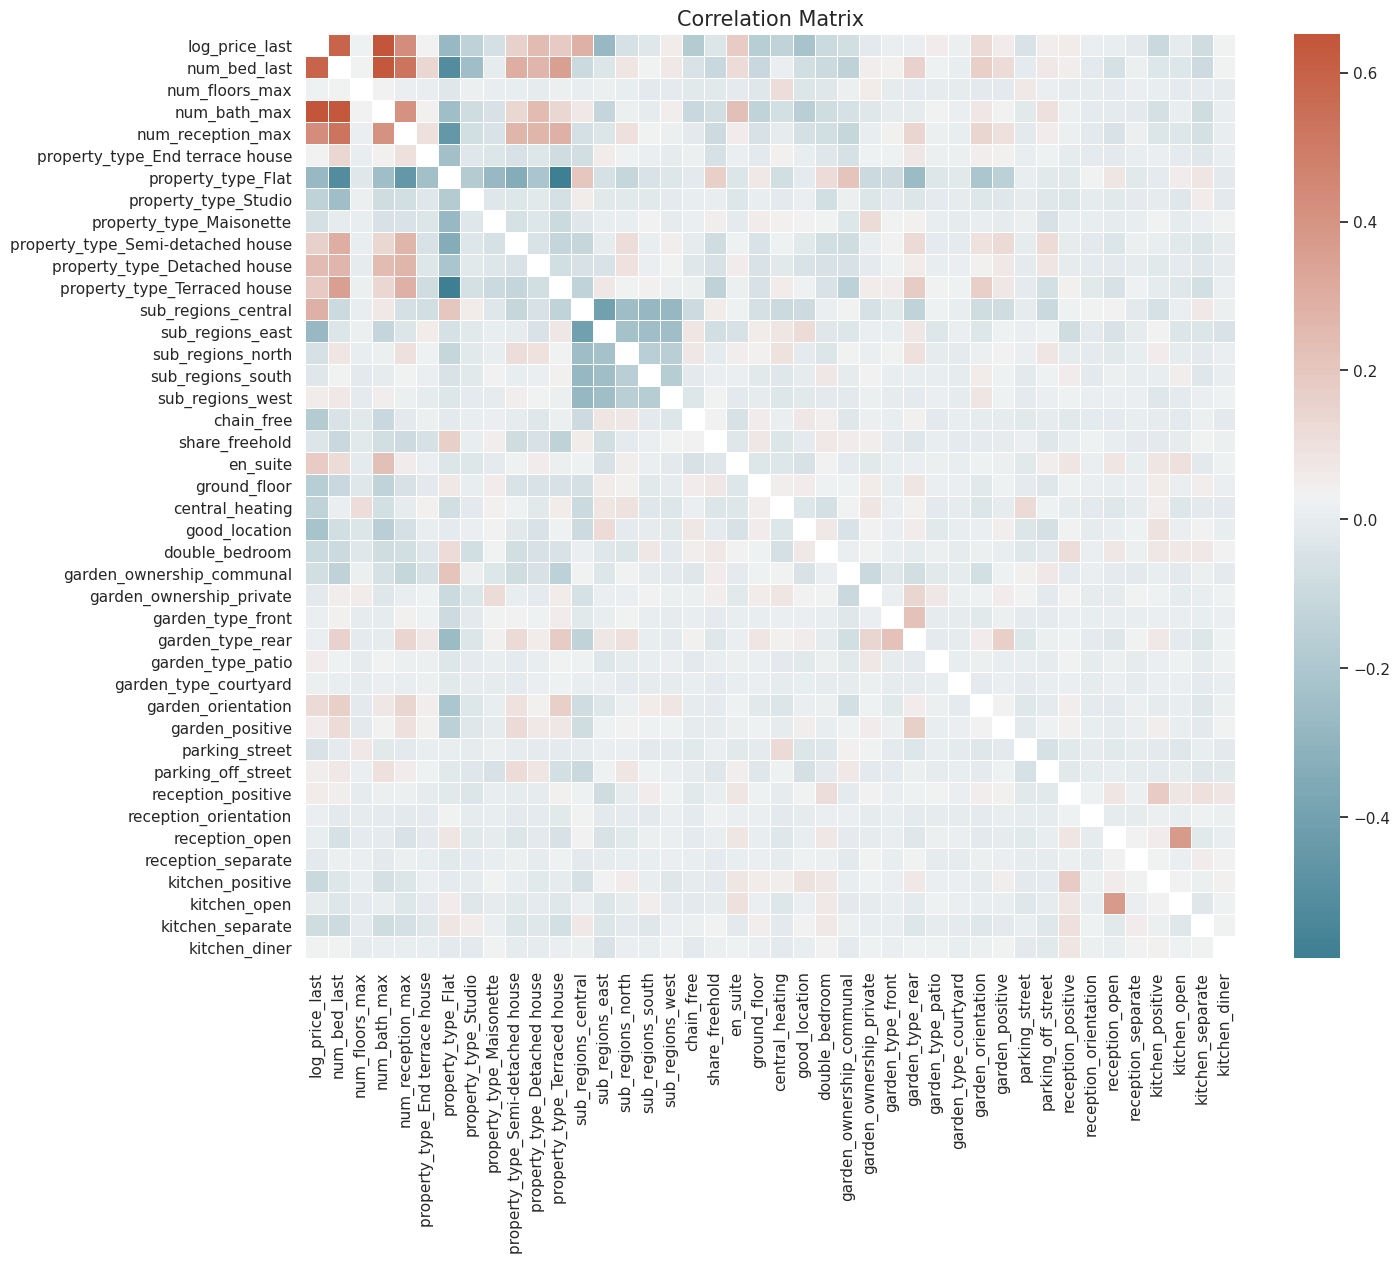

In [263]:
# correlation matrix 
#correlation plot 
# tmp = df_text.drop(columns=[x for x in df_text.columns.values if (x.startswith('num') or x.startswith('property_type'))])
f,ax = plt.subplots(figsize=(15, 12))
corrtbl = df_text.corr()
sns.heatmap(corrtbl[(corrtbl < 0.99)], 
            cmap=sns.diverging_palette(220, 20, n=200),
#             cmap=sns.color_palette("YlOrBr", as_cmap=True),
            linewidths=.5, fmt= '.1f',ax=ax,
            annot=False)
ax.set_title('Correlation Matrix',fontsize=15)

####  5.2.1 Lasso Regression 

In [264]:
# increase the max_iter to guarantee convergence
lasso_model = sklearn.linear_model.Lasso(alpha=0.01, max_iter=10000, random_state=42)
lasso_model.fit(X=train_x, y=train_y)

# print(lasso_model.coef_)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
print(df_coef_lasso)

# using the model.score function to get the R2 on the train, val, and testing data
print('R2 of train: ',lasso_model.score(X=train_x, y=train_y))
# print('R2 of val: ',lasso_model.score(X=val_x, y=val_y))
print('R2 of test: ',lasso_model.score(X=test_x, y=test_y))

                                  var                  coef
0   num_bed_last                      0.16718190746445274  
1   num_floors_max                    0.0                  
2   num_bath_max                      0.25791373188169625  
3   num_reception_max                 0.09016460374427661  
4   property_type_End terrace house   -0.0                 
5   property_type_Flat                -0.0                 
6   property_type_Studio              -0.0                 
7   property_type_Maisonette          -0.0                 
8   property_type_Semi-detached house 0.0                  
9   property_type_Detached house      0.0                  
10  property_type_Terraced house      0.0                  
11  sub_regions_central               0.3038668723625592   
12  sub_regions_east                  -0.11562470879112415 
13  sub_regions_north                 -0.01704427036950997 
14  sub_regions_south                 0.0                  
15  sub_regions_west                  0.

In [265]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = lasso_model.predict(train_x)
mse_train = mean_squared_error(train_y, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = lasso_model.predict(test_x)
mse_test =mean_squared_error(test_y, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 0.17
MSE test set 0.18


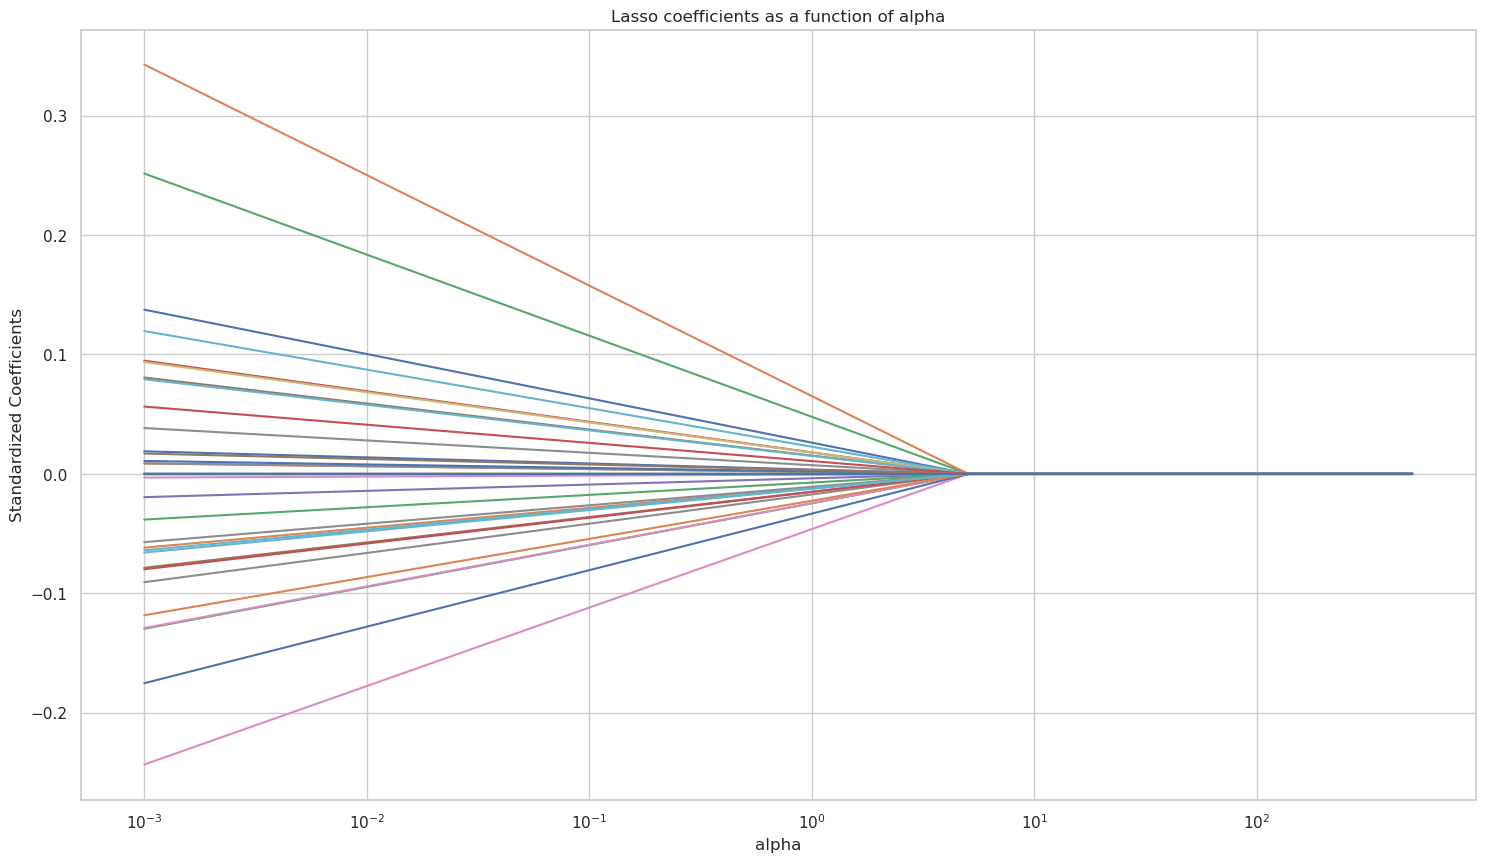

In [266]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = sklearn.linear_model.Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(train_x, train_y)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [267]:
#find the best alpha 
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=10,random_state=42, max_iter=10000).fit(train_x, train_y)

In [268]:
model.alpha_

0.0005077325324855727

In [269]:
#after getting the best alpha, run the model again  
# increase the max_iter to guarantee convergence
lasso_model = sklearn.linear_model.Lasso(alpha=0.0005077325324855727, max_iter=10000, random_state=42)
lasso_model.fit(X=train_x, y=train_y)

# print(lasso_model.coef_)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
print(df_coef_lasso)

# using the model.score function to get the R2 on the train, val, and testing data
print('R2 of train: ',lasso_model.score(X=train_x, y=train_y))
# print('R2 of val: ',lasso_model.score(X=val_x, y=val_y))
print('R2 of test: ',lasso_model.score(X=test_x, y=test_y))

                                  var                  coef
0   num_bed_last                      0.13293278358015018  
1   num_floors_max                    0.010631659282662707 
2   num_bath_max                      0.25149393035832907  
3   num_reception_max                 0.09316872895312212  
4   property_type_End terrace house   -0.047789705832209296
5   property_type_Flat                -0.10257200501322311 
6   property_type_Studio              -0.30084956710471933 
7   property_type_Maisonette          -0.12092236548860934 
8   property_type_Semi-detached house 0.0                  
9   property_type_Detached house      0.1286435952377905   
10  property_type_Terraced house      0.00800867572982228  
11  sub_regions_central               0.34561075649736056  
12  sub_regions_east                  -0.12970430444449482 
13  sub_regions_north                 -0.08433162005287298 
14  sub_regions_south                 0.0                  
15  sub_regions_west                  0.

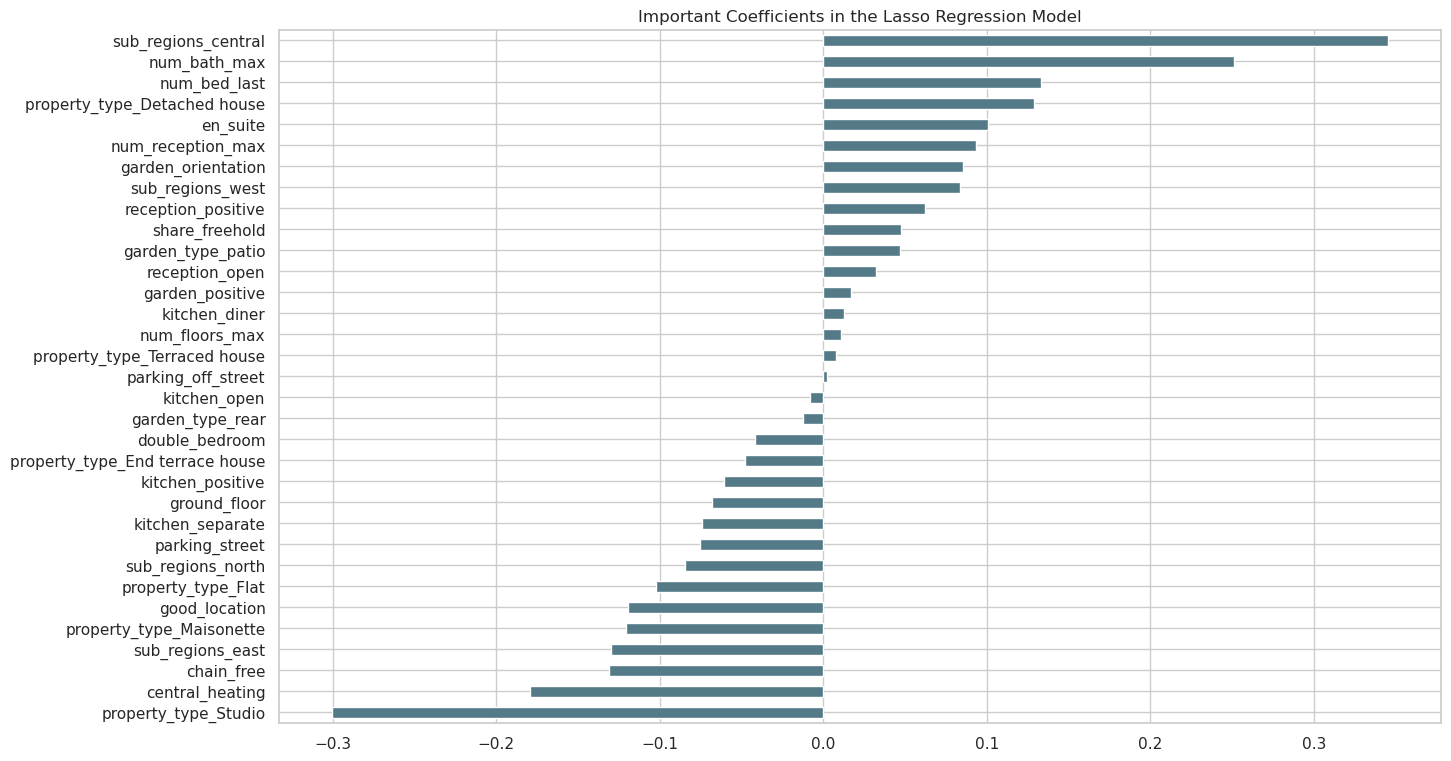

In [270]:
# Plot important coefficients
coefs = pd.Series(lasso_model.coef_, index = train_x.columns)
imp_coefs = pd.concat([coefs.sort_values().head(16),
                     coefs.sort_values().tail(17)])
plt.figure(figsize = (15, 9))
sns.set_style("whitegrid")
imp_coefs.plot(kind = "barh",color='#547987')
plt.title("Important Coefficients in the Lasso Regression Model")
plt.show()

In [271]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, lasso_model.predict(test_x))

0.16510208697665882

(0.0003594471059678432,
 0.7171912647622636,
 0.1254829099957508,
 0.45217270779003726)

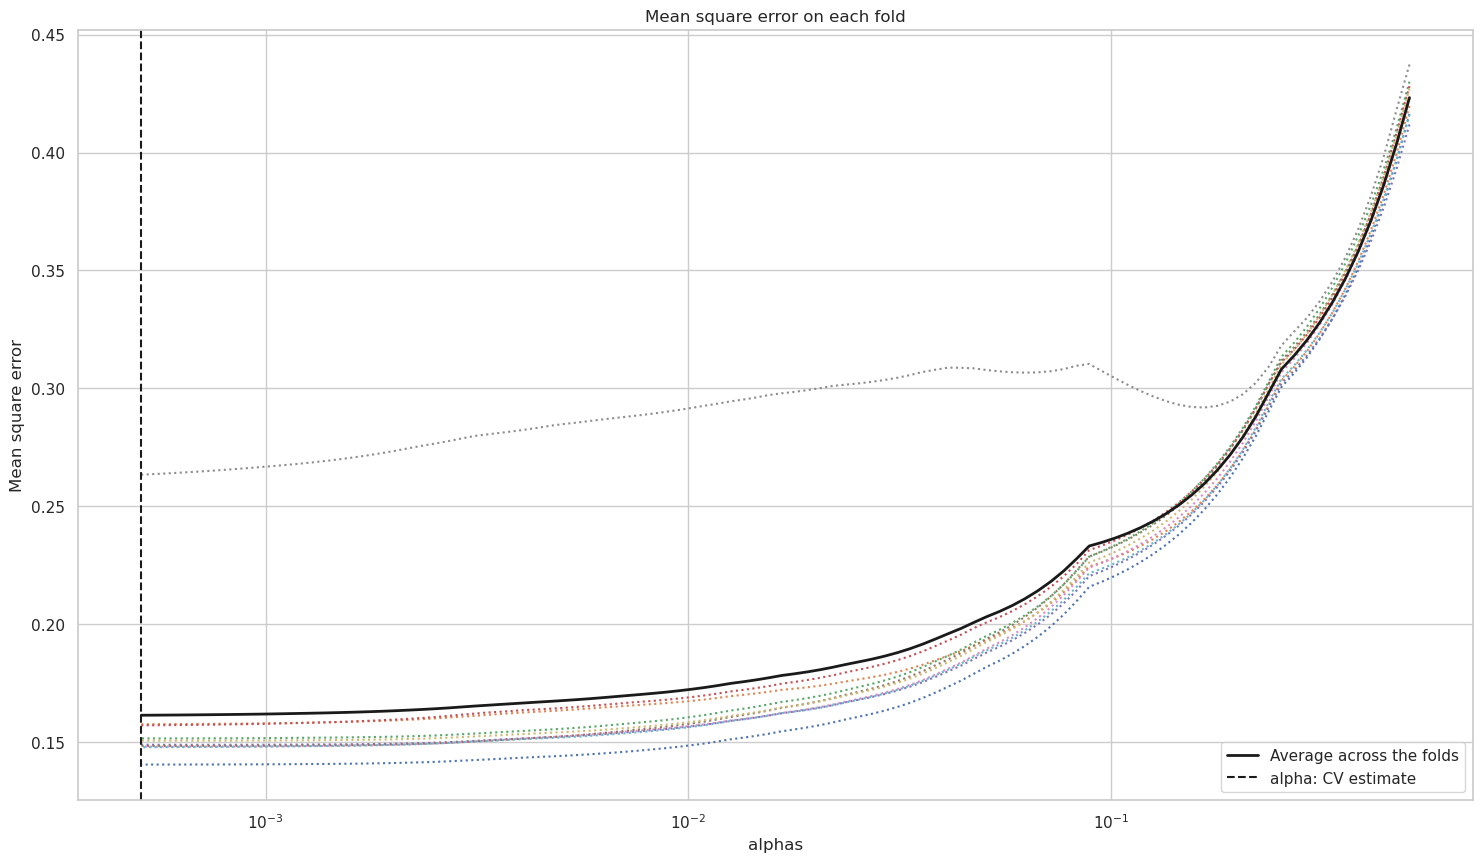

In [272]:
#model evaluation 
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")



#### 5.2.2 GBDT

In [273]:
%%time
xgb_model = xgb.XGBRegressor(random_state = random_state_xgb)
xgb_model.fit(train_x, train_y)

CPU times: user 27.2 s, sys: 147 ms, total: 27.4 s
Wall time: 3.56 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=43,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [274]:
#check the result by using default parameters 
print("R2 on the training data:")
print(xgb_model.score(X=train_x, y=train_y))
# print("R2 on the val data:")
# print(xgb_model.score(X=val_x, y=val_y))
print("R2 on the testing data:")
print(xgb_model.score(X=test_x, y=test_y))

R2 on the training data:
0.7434421020187403
R2 on the testing data:
0.724723236389593


In [275]:
#tuning the n_estimator and learning rates


parameters = {'n_estimators':[30,35,40],
              'learning_rate':[0.25,0.26,0.27],
              'max_depth':[3,4,5],
              'min_child_weight':range(1,6,2)
             }
xgb_model = xgb.XGBRegressor()

#cv=5 by default, which means 5-fold cross-validation
clf_xgb = model_selection.GridSearchCV(xgb_model, parameters)

clf_xgb.fit(val_x, val_y)

#we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf_xgb.best_params_)
print ("The best score is: ")
print (clf_xgb.best_score_)

The best parameter value is: 
{'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 40}
The best score is: 
0.6683376311694396


In [276]:
#running the xgb model again to get the optimal results (manully input the optimal hyperparameters) 

xgb_model_final = xgb.XGBRegressor(n_estimators=40,
                                   max_depth=5,
                                   learning_rate = 0.25,
                                   min_child_weight=3,
                                   random_state = random_state_xgb)

xgb_model_final.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=8, num_parallel_tree=1, random_state=43,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [277]:
print("R2 on the training data:")
print(xgb_model_final.score(X=train_x, y=train_y))
print("R2 on the val data:")
# print(xgb_model_final.score(X=val_x, y=val_y))
print("R2 on the testing data:")
print(xgb_model_final.score(X=test_x, y=test_y))

R2 on the training data:
0.7150080027939059
R2 on the val data:
R2 on the testing data:
0.712032963003232


                                       Importance
num_bath_max                 0.4268374741077423  
sub_regions_central          0.11109308898448944 
sub_regions_east             0.07951607555150986 
num_bed_last                 0.06150108948349953 
num_reception_max            0.034418970346450806
property_type_Detached house 0.026508446782827377
central_heating              0.024948714300990105
chain_free                   0.02441825531423092 
good_location                0.019565684720873833
sub_regions_west             0.018109802156686783
double_bedroom               0.016727281734347343
sub_regions_north            0.014255329966545105
garden_orientation           0.013994896784424782
property_type_Studio         0.011845854111015797
ground_floor                 0.011525426059961319


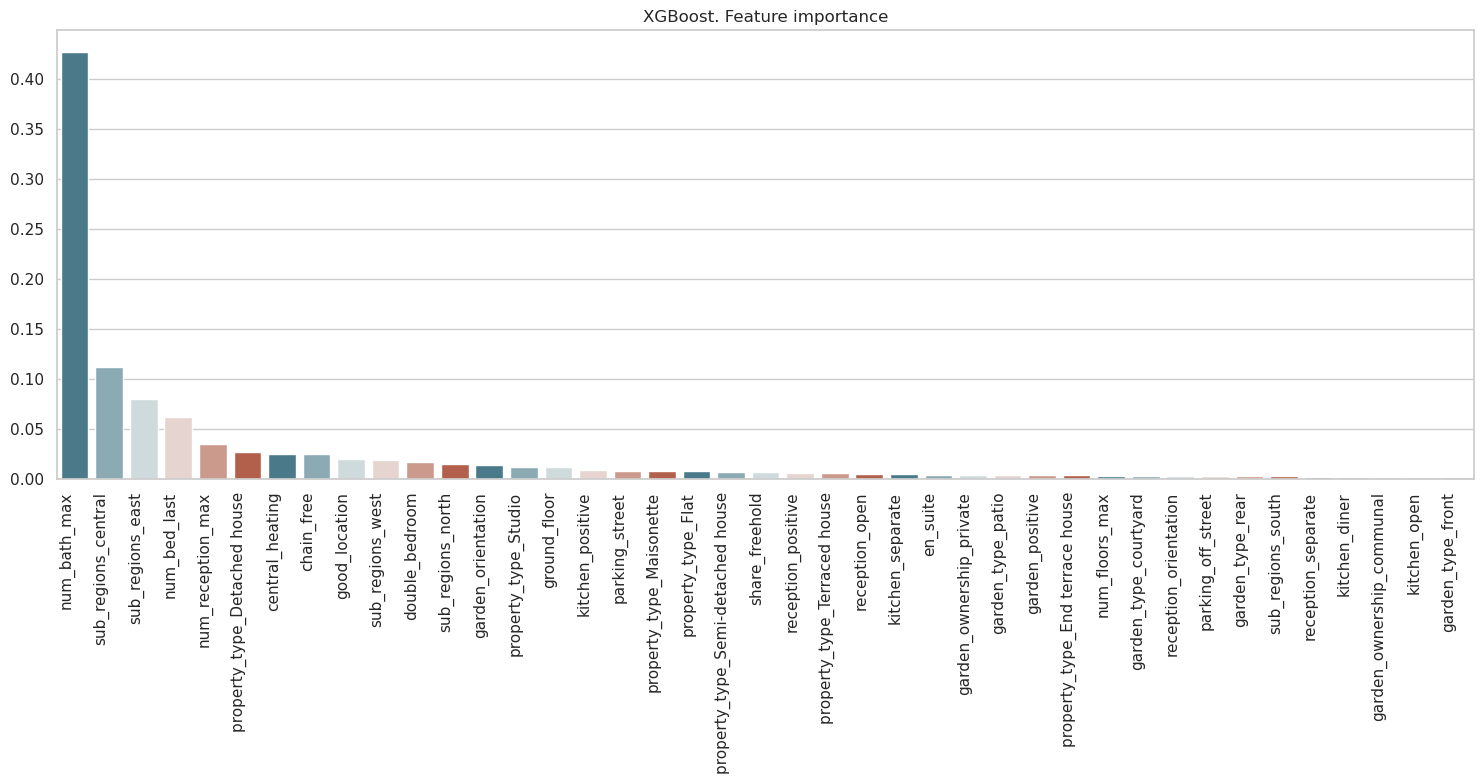

In [278]:
# Calculate feature importances
XGB_importances = xgb_model_final.feature_importances_
# Visualize Feature Importance
# Sort feature importances in descending order
XGB_indices = np.argsort(XGB_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
XGB_names = [train_x.columns[i] for i in XGB_indices]

#create dataframe for the importance of variables 
XGBoost_importance = pd.DataFrame(XGB_importances[XGB_indices],XGB_names,columns=['Importance'])

#print the most important features 
print(XGBoost_importance.head(15))

plt.figure(figsize = (15, 8))
sns.set_style("whitegrid")
chart = sns.barplot(x = XGB_names, y=XGB_importances[XGB_indices],palette=sns.diverging_palette(220, 20))
plt.xticks(rotation=90, horizontalalignment='right', fontweight='light')
plt.title('XGBoost. Feature importance')
plt.tight_layout()

In [279]:
#building linear model 
#just a reference 
import pandas
import statsmodels.api as sm

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:         log_price_last   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     4573.
Date:                Sun, 21 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:29:55   Log-Likelihood:                -54302.
No. Observations:              109081   AIC:                         1.087e+05
Df Residuals:                  109040   BIC:                         1.091e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

## 6. Discussion and further analysis

In [280]:
df_text

log_price_last  num_bed_last  num_floors_max  num_bath_max  \
0      13.710150042306449  1             0               1              
1      13.458835614025542  2             0               2              
2      13.997832114758229  4             0               2              
3      14.20077295875492   2             1               2              
4      14.03705282791151   2             0               2              
...                  ...  ..            ..              ..              
138639 14.430696197054507  5             0               3              
138640 13.652991628466498  2             0               2              
138641 13.635181015791112  2             0               2              
138643 12.691580461311874  1             0               1              
138644 12.706847933442663  1             0               1              

        num_reception_max  property_type_End terrace house  \
0       1                  0                                 
1       1                  0                                 
2       1                  0                                 
3       1                  0                                 
4       1                  0                                 
...    ..                 ..                                 
138639  2                  0                                 
138640  1                  0                                 
138641  1                  0                                 
138643  1                  0                                 
138644  1                  0                                 

        property_type_Flat  property_type_Studio  property_type_Maisonette  \
0       1                   0                     0                          
1       1                   0                     0                          
2       1                   0                     0                          
3       1                   0                     0                          
4       1                   0                     0                          
...    ..                  ..                    ..                          
138639  0                   0                     0                          
138640  1                   0                     0                          
138641  1                   0                     0                          
138643  1                   0                     0                          
138644  1                   0                     0                          

        property_type_Semi-detached house  ...  parking_street  \
0       0                                  ...  0                
1       0                                  ...  0                
2       0                                  ...  0                
3       0                                  ...  0                
4       0                                  ...  0                
...    ..                                  ... ..                
138639  1                                  ...  0                
138640  0                                  ...  0                
138641  0                                  ...  0                
138643  0                                  ...  0                
138644  0                                  ...  0                

        parking_off_street  reception_positive  reception_orientation  \
0       0                   0                   0                       
1       0                   0                   0                       
2       0                   0                   0                       
3       0                   0                   0                       
4       0                   0                   0                       
...    ..                  ..                  ..                       
138639  1                   0                   0                       
138640  0                   0                   0                       
13

In [281]:
df_dis=pd.merge(df, df_text, left_index=True, right_index=True)

In [282]:
df_dis.columns

Index(['listing_id', 'price_last', 'property_type', 'num_bed_last_x',
       'num_floors_max_x', 'num_bath_max_x', 'num_reception_max_x', 'bullet',
       'sub_regions', 'log_price_last_x', 'lower', 'removing_html',
       'removing_accented', 'expand_contractions', 'removing_numbers',
       'removing_stopwords', 'removing_punctuation', 'removing_tagged_pos',
       'removing_tagged_pos_str', 'removing_punctuation_1', 'cleaned',
       'tokens', 'log_price_last_y', 'num_bed_last_y', 'num_floors_max_y',
       'num_bath_max_y', 'num_reception_max_y',
       'property_type_End terrace house', 'property_type_Flat',
       'property_type_Studio', 'property_type_Maisonette',
       'property_type_Semi-detached house', 'property_type_Detached house',
       'property_type_Terraced house', 'sub_regions_central',
       'sub_regions_east', 'sub_regions_north', 'sub_regions_south',
       'sub_regions_west', 'chain_free', 'share_freehold', 'en_suite',
       'ground_floor', 'central_heating', 

In [283]:
df_dis=df_dis[['price_last', 'log_price_last_x','property_type','sub_regions','bullet','cleaned','num_bed_last_x',
       'num_floors_max_x', 'num_bath_max_x', 'num_reception_max_x','property_type_End terrace house', 'property_type_Flat',
       'property_type_Studio', 'property_type_Maisonette',
       'property_type_Semi-detached house', 'property_type_Detached house',
       'property_type_Terraced house', 'sub_regions_central',
       'sub_regions_east', 'sub_regions_north', 'sub_regions_south',
       'sub_regions_west', 'chain_free', 'share_freehold', 'en_suite',
       'ground_floor', 'central_heating', 'good_location', 'double_bedroom',
       'garden_ownership_communal', 'garden_ownership_private',
       'garden_type_front', 'garden_type_rear', 'garden_type_patio',
       'garden_type_courtyard', 'garden_orientation', 'garden_positive',
       'parking_street', 'parking_off_street', 'reception_positive',
       'reception_orientation', 'reception_open', 'reception_separate',
       'kitchen_positive', 'kitchen_open', 'kitchen_separate',
       'kitchen_diner']]

In [284]:
df_dis.chain_free.value_counts()

0    90209
1    18872
Name: chain_free, dtype: int64

In [285]:
df_dis.double_bedroom.value_counts()

0    81698
1    27383
Name: double_bedroom, dtype: int64

In [286]:
#calculate the overall score 
df_dis['score']=df_dis[['chain_free', 'share_freehold', 'en_suite',
       'ground_floor', 'central_heating', 'good_location', 'double_bedroom',
       'garden_ownership_communal', 'garden_ownership_private',
       'garden_type_front', 'garden_type_rear', 'garden_type_patio',
       'garden_type_courtyard', 'garden_orientation', 'garden_positive',
       'parking_street', 'parking_off_street', 'reception_positive',
       'reception_orientation', 'reception_open', 'reception_separate',
       'kitchen_positive', 'kitchen_open', 'kitchen_separate',
       'kitchen_diner']].sum(axis=1)

<AxesSubplot:>

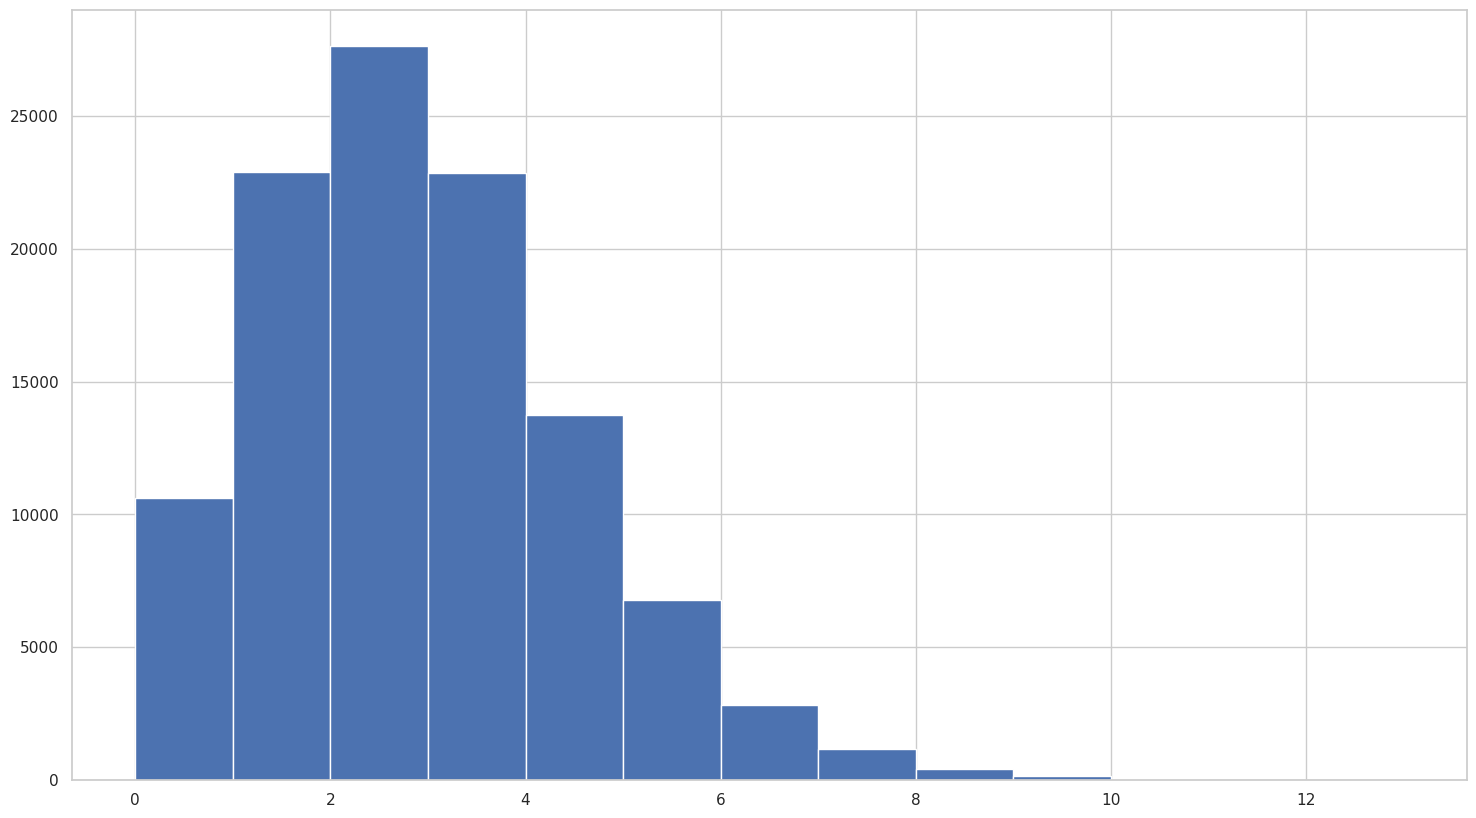

In [287]:
df_dis.score.hist(bins=13)

In [288]:
pd.options.display.float_format = '{:,.5f}'.format
table=df_dis.groupby(['score']).mean()
table

price_last  log_price_last_x  num_bed_last_x  num_floors_max_x  \
score                                                                       
0     1,288,764.58347 13.64818          2.51781         0.05078             
1     1,022,168.10785 13.48555          2.42490         0.06973             
2     819,708.74643   13.35635          2.45095         0.06186             
3     723,066.17660   13.28357          2.44373         0.07929             
4     681,787.79314   13.24967          2.37984         0.05163             
5     644,036.70224   13.22323          2.35415         0.05698             
6     634,554.97650   13.23270          2.34318         0.04628             
7     644,583.45184   13.24306          2.31173         0.05867             
8     629,844.33254   13.24480          2.32067         0.08551             
9     616,291.35338   13.26518          2.42857         0.02256             
10    574,060.00000   13.21012          2.23333         0.03333             
11    958,495.00000   13.62472          2.60000         0.10000             
12    530,000.00000   13.18063          3.00000         0.00000             
13    550,000.00000   13.21767          3.00000         1.00000             

       num_bath_max_x  num_reception_max_x  property_type_End terrace house  \
score                                                                         
0     1.74411         1.28133              0.02525                            
1     1.62335         1.22570              0.02982                            
2     1.50930         1.21042              0.03410                            
3     1.43464         1.19930              0.03656                            
4     1.39955         1.18760              0.03905                            
5     1.37673         1.18172              0.03912                            
6     1.38946         1.19509              0.03453                            
7     1.38529         1.20403              0.03240                            
8     1.44656         1.16627              0.02613                            
9     1.39850         1.19549              0.03759                            
10    1.50000         1.16667              0.00000                            
11    2.40000         1.00000              0.00000                            
12    1.00000         1.00000              0.00000                            
13    2.00000         1.00000              0.00000                            

       property_type_Flat  property_type_Studio  property_type_Maisonette  \
score                                                                       
0     0.63407             0.02987               0.02911                     
1     0.64938             0.02947               0.02921                     
2     0.62351             0.01987               0.03757                     
3     0.60512             0.01211               0.04793                     
4     0.60765             0.00938               0.05941                     
5     0.60585             0.00620               0.07691                     
6     0.62086             0.00285               0.08722                     
7     0.66112             0.00175               0.07005                     
8     0.66508             0.00000               0.08314                     
9     0.59398             0.00000               0.09774                     
10    0.53333             0.00000               0.16667                     
11    0.70000             0.00000               0.10000                     
12    1.00000             0.00000               0.00000                     
13    0.00000             0.00000               1.00000                     

       ...  parking_street  parking_off_street  reception_positive  \
score  ...                                                           
0      ... 0.00000         0.00000             0.00000               
1      ... 0.01851         0.10942             0.01917               


In [289]:
table.columns

Index(['price_last', 'log_price_last_x', 'num_bed_last_x', 'num_floors_max_x',
       'num_bath_max_x', 'num_reception_max_x',
       'property_type_End terrace house', 'property_type_Flat',
       'property_type_Studio', 'property_type_Maisonette',
       'property_type_Semi-detached house', 'property_type_Detached house',
       'property_type_Terraced house', 'sub_regions_central',
       'sub_regions_east', 'sub_regions_north', 'sub_regions_south',
       'sub_regions_west', 'chain_free', 'share_freehold', 'en_suite',
       'ground_floor', 'central_heating', 'good_location', 'double_bedroom',
       'garden_ownership_communal', 'garden_ownership_private',
       'garden_type_front', 'garden_type_rear', 'garden_type_patio',
       'garden_type_courtyard', 'garden_orientation', 'garden_positive',
       'parking_street', 'parking_off_street', 'reception_positive',
       'reception_orientation', 'reception_open', 'reception_separate',
       'kitchen_positive', 'kitchen_open', 'kitc

In [290]:
table_select1=table[['price_last', 'log_price_last_x','num_bed_last_x', 'num_floors_max_x',
       'num_bath_max_x', 'num_reception_max_x',
       'property_type_End terrace house', 'property_type_Flat',
       'property_type_Studio', 'property_type_Maisonette',
       'property_type_Semi-detached house', 'property_type_Detached house',
       'property_type_Terraced house', 'sub_regions_central',
       'sub_regions_east', 'sub_regions_north', 'sub_regions_south',
       'sub_regions_west']]
table_select1[0:10]

price_last  log_price_last_x  num_bed_last_x  num_floors_max_x  \
score                                                                       
0     1,288,764.58347 13.64818          2.51781         0.05078             
1     1,022,168.10785 13.48555          2.42490         0.06973             
2     819,708.74643   13.35635          2.45095         0.06186             
3     723,066.17660   13.28357          2.44373         0.07929             
4     681,787.79314   13.24967          2.37984         0.05163             
5     644,036.70224   13.22323          2.35415         0.05698             
6     634,554.97650   13.23270          2.34318         0.04628             
7     644,583.45184   13.24306          2.31173         0.05867             
8     629,844.33254   13.24480          2.32067         0.08551             
9     616,291.35338   13.26518          2.42857         0.02256             

       num_bath_max_x  num_reception_max_x  property_type_End terrace house  \
score                                                                         
0     1.74411         1.28133              0.02525                            
1     1.62335         1.22570              0.02982                            
2     1.50930         1.21042              0.03410                            
3     1.43464         1.19930              0.03656                            
4     1.39955         1.18760              0.03905                            
5     1.37673         1.18172              0.03912                            
6     1.38946         1.19509              0.03453                            
7     1.38529         1.20403              0.03240                            
8     1.44656         1.16627              0.02613                            
9     1.39850         1.19549              0.03759                            

       property_type_Flat  property_type_Studio  property_type_Maisonette  \
score                                                                       
0     0.63407             0.02987               0.02911                     
1     0.64938             0.02947               0.02921                     
2     0.62351             0.01987               0.03757                     
3     0.60512             0.01211               0.04793                     
4     0.60765             0.00938               0.05941                     
5     0.60585             0.00620               0.07691                     
6     0.62086             0.00285               0.08722                     
7     0.66112             0.00175               0.07005                     
8     0.66508             0.00000               0.08314                     
9     0.59398             0.00000               0.09774                     

       property_type_Semi-detached house  property_type_Detached house  \
score                                                                    
0     0.05493                            0.03458                         
1     0.05716                            0.03057                         
2     0.06668                            0.02577                         
3     0.07277                            0.02598                         
4     0.06799                            0.02399                         
5     0.06894                            0.01949                         
6     0.06408                            0.02207                         
7     0.06217                            0.01751                         
8     0.07363                            0.01900                         
9     0.06767                            0.01504                         

       property_type_Terraced house  sub_regions_central  sub_regions_east  \
score                                                                        
0     0.16874                       0.45534              0.18890             
1     0.15916                       0.39106              0.25413             
2     0.178

In [291]:
pd.options.display.float_format = '{:,.2f}'.format
table_select2=table[['price_last', 'log_price_last_x','chain_free','ground_floor', 'central_heating', 'good_location', 'double_bedroom','garden_orientation'
                    ]]
table_select2[0:10]

price_last  log_price_last_x  chain_free  ground_floor  \
score                                                            
0     1,288,764.58 13.65             0.00        0.00            
1     1,022,168.11 13.49             0.05        0.05            
2     819,708.75   13.36             0.16        0.11            
3     723,066.18   13.28             0.23        0.18            
4     681,787.79   13.25             0.29        0.26            
5     644,036.70   13.22             0.33        0.35            
6     634,554.98   13.23             0.36        0.42            
7     644,583.45   13.24             0.37        0.53            
8     629,844.33   13.24             0.39        0.52            
9     616,291.35   13.27             0.35        0.68            

       central_heating  good_location  double_bedroom  garden_orientation  
score                                                                      
0     0.00             0.00           0.00            0.00                 
1     0.04             0.35           0.08            0.02                 
2     0.07             0.51           0.21            0.05                 
3     0.12             0.59           0.32            0.07                 
4     0.12             0.68           0.45            0.09                 
5     0.15             0.73           0.53            0.11                 
6     0.19             0.77           0.60            0.12                 
7     0.26             0.83           0.59            0.14                 
8     0.30             0.86           0.62            0.13                 
9     0.42             0.92           0.53            0.15

1. cheaper properties tends to use more common descriptions to self promote themselves (大众特证越多，可能说明他们越没有引人瞩目的特征）

the score with get more keywords usually have a lower average property price.
the common appeared feature does not indicate a good quality, the zero score has the highest average price. while when the score becomes higher, the average property price decrease. Cheaper properties tends to use more description and common keyword features to self-promotion. However, the more expensive properties, their keyword features are not common, (one specualtion is that this study does not catch the minority features of expensive properties. However, more cheaper properties tends to use more description to self promotion)

2. the keyword features of expensive properties still need to be explored

the keyword featrues for great amount of high end properties have not been explored. These features are not the most common ones, but could be the most influential features.

<AxesSubplot:xlabel='price_last', ylabel='score'>

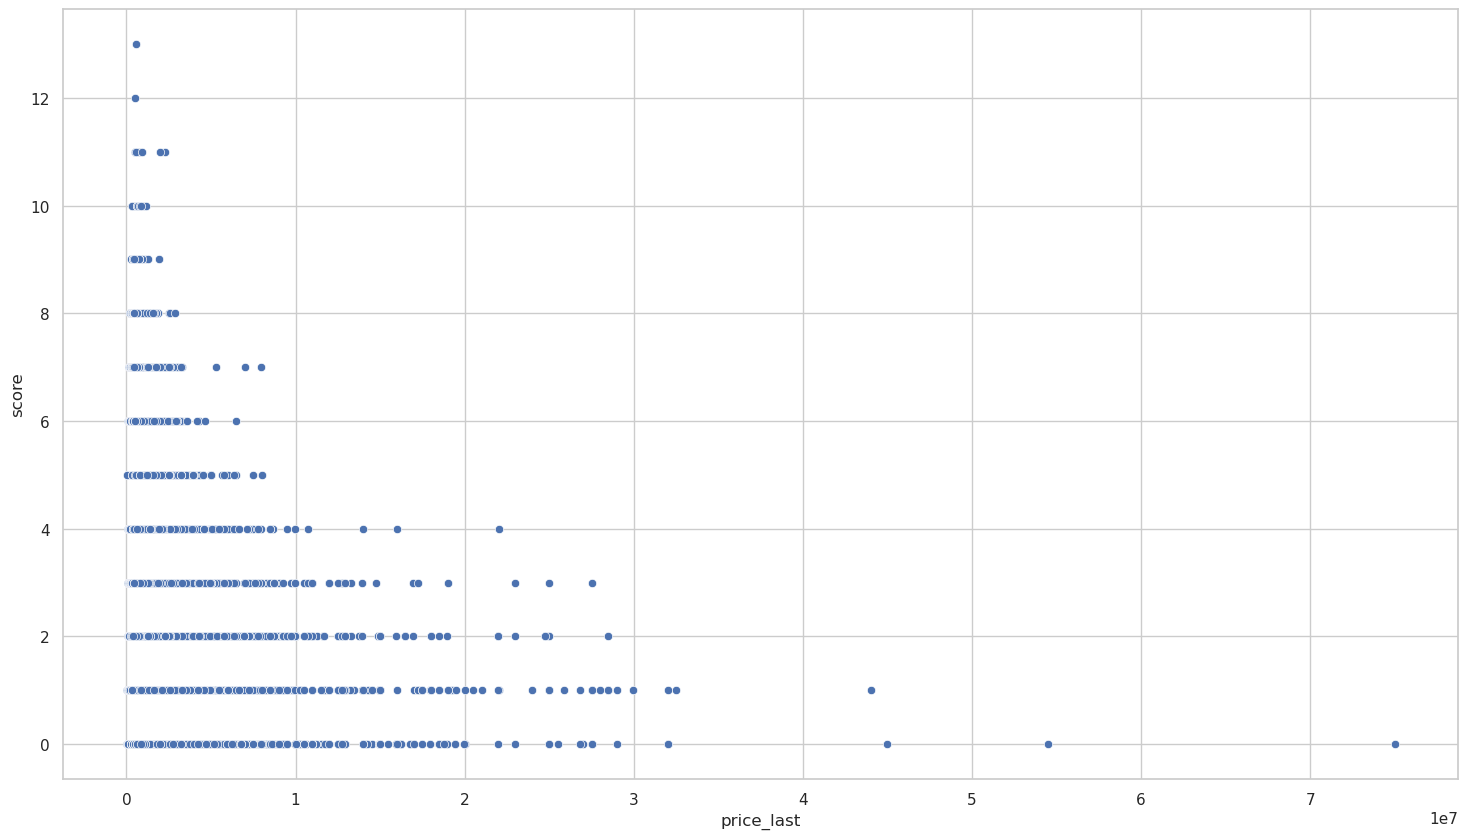

In [292]:
sns.scatterplot(data=df_dis, y="score", x='price_last')

Text(0.5, 1.0, 'Correlation Matrix')

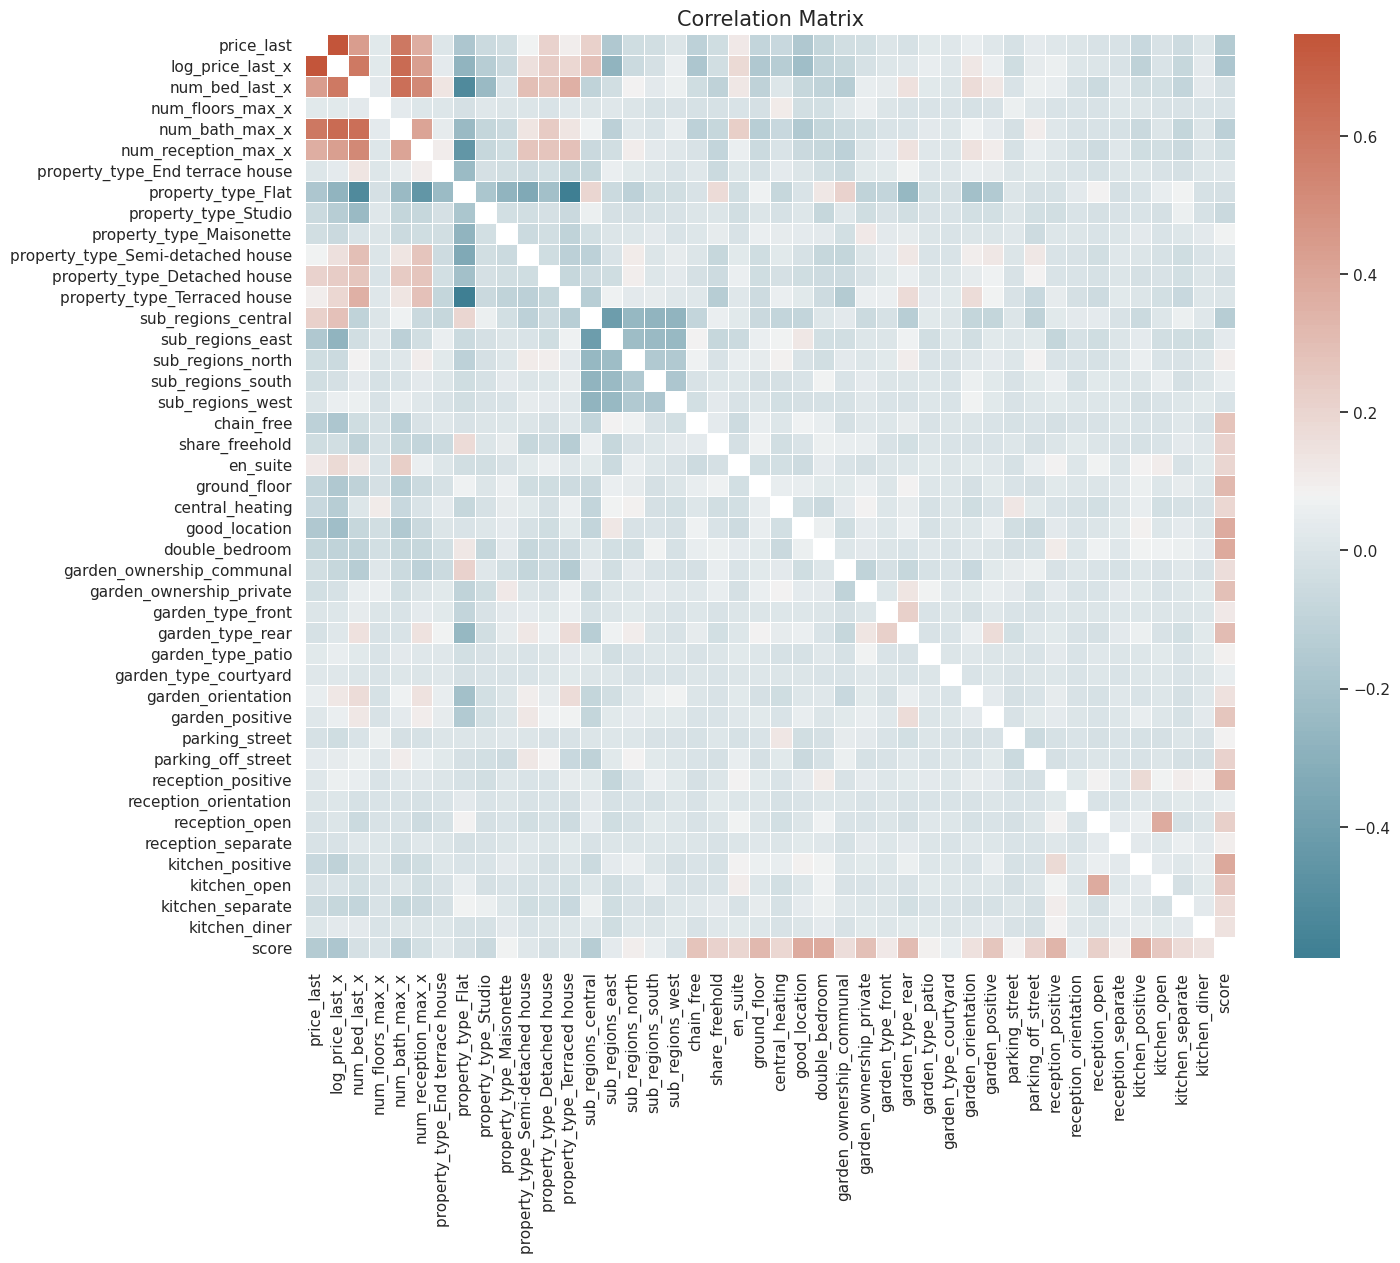

In [293]:
# correlation matrix 
#correlation plot 
# tmp = df_text.drop(columns=[x for x in df_text.columns.values if (x.startswith('num') or x.startswith('property_type'))])
f,ax = plt.subplots(figsize=(15, 12))
corrtbl = df_dis.corr()
sns.heatmap(corrtbl[(corrtbl < 0.99)], 
            cmap=sns.diverging_palette(220, 20, n=200),
#             cmap=sns.color_palette("YlOrBr", as_cmap=True),
            linewidths=.5, fmt= '.1f',ax=ax,
            annot=False)
ax.set_title('Correlation Matrix',fontsize=15)